In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import find_peaks
import sys 
import random
import scipy as sp
from scipy import optimize
from scipy.optimize import least_squares
from scipy.special import erf
from time import time
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from os.path import join, exists
from platform import uname
from datetime import datetime
import matplotlib.patheffects as pe
from configparser import ConfigParser

In [2]:
def Weighted_Independent_Blocks(x, w, block_dim, verbose = False):

    #  returns a reshaped version of a random variable x with its weights w
    #  by considering as independent not all the elements of x, but blocks of a dimension dim (decided a priori)

    dim = len(x)
    n_block = int(dim/block_dim)

    if n_block == 0: n_block = 1

    X = np.zeros(n_block)
    W = np.zeros(n_block)

    for ii in range(n_block):

        i0 = ii*block_dim
        i1 = (ii+1)*block_dim

        if i1> dim: 
            X[ii] = np.average(x[i0:], weights=w[i0:])
            W[ii] = np.sum(w[i0:])
            break

        else:
            #print(i0, i1)
            #print(x[i0:i1], w[i0:i1])
            X[ii] = np.average(x[i0:i1], weights=w[i0:i1])
            W[ii] = np.sum(w[i0:i1])

    if verbose: print('Completed.\nInitial dimension = {}\nBlock dimension = {}\nn_block = {}'.format(dim, block_dim, n_block))

    return X, W

def Get_Sigma_from_Bootstrapping(X, W, n_boot, n_block, ):

    """
    Returns the std deviation by bootstrapping analysis for the population X with weights W 
    (OSS: in our case for now X, W come out from block analysis performed with Weighted_Independent_Blocks() )
    """

    ave_boot = np.zeros(n_boot)
    for ii_boot in range(n_boot):
        blocks = random.choices(range(n_block), k = n_block)
        ave_boot[ii_boot] = np.average(X[blocks], weights=W[blocks])

    # return the sigma
    return np.std(ave_boot)



def Weighted_Sigma_of_Mean(x, w,):

    # return the best estimator of the variance of the mean of a random variable x with weights w

    return np.sqrt((np.sum(w**2 * (x - np.average(x, weights = w))**2))/(np.sum(w)**2))

In [3]:
def read_cs_md(data):

 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
 for lines in open(data, "r").readlines():
        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[] 
        timeseries=np.asarray(riga[2:-1]).astype(float)
        confd[key2][key]=timeseries
 return(confd)

def read_exp_cs(data):
 confd = { 'HA': { },
          'CA': { },
          'CB': { },
          'C': { },
          'H': { },
          'HA2':{ },
          'HA3':{ },
          'N': { }}
          
 for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        # key dictionary
        key=riga[0]
        key2=riga[1]
        confd[key2][key]=[]
        confd[key2][key] += map(float, [float(riga[2])])
 return(confd)

def add_md_data(data,dict,key,):
  dict[key]={}
  for lines in open(data, "r").readlines():

        riga=lines.strip().split(",")
        #riga=lines.strip().split(" ")
        key2=riga[0]
        timeseries=np.asarray(riga[1:-1]).astype(float)
        dict[key][key2]=[]
        dict[key][key2]=(timeseries)
  return(dict)

def add_exp_data(data,dict,key):
  dict[key]={}
  for lines in open(data, "r").readlines():
        #riga=lines.strip().split(",")
        riga=lines.strip().split(" ")
        key2=riga[0]
        dict[key][key2]=[]
        dict[key][key2] += map(float, [float(riga[1])])
  return(dict)

def add_md_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)
  return(dict)

def add_md_scalar_skip0(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)[0:-1]
  return(dict)

def add_exp_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=[data]
  return(dict)

def add_md_scalar_skip0(data,dict,key):
  dict[key]={}
  dict[key][0]=np.loadtxt(data)[1:]
  return(dict)

def add_exp_scalar(data,dict,key):
  dict[key]={}
  dict[key][0]=[data]
  return(dict)


def scale_rdc_Q_fit(exp,calc):
     def residuals(p,y,x):
         c = p
         err = ((c*y)-x)
         return err
     p0=0.0001
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     c,d=leastsq(residuals,p0,args=(calc,exp))
     fit=c*calc
     #print("Calc:",calc,"Fit:",fit)
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_i=(sum(np.square(calc-exp))/len(exp))**0.5
     rmsd_f=(sum(np.square(fit-exp))/len(exp))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit
    

def scale_rdc_Q(exp,calc):
     exp  = np.trim_zeros(exp)
     calc = np.trim_zeros(calc)
     Q_i=(np.sum(np.square(exp-calc))/(np.sum(np.square(exp))))**.5
     c=np.linalg.norm(np.dot(exp,calc))/(np.dot(calc,calc))
     fit=c*calc
     Q_f=(np.sum(np.square(exp-fit))/(np.sum(np.square(exp))))**.5
     rmsd_f=(sum(np.square(fit-exp))/len(exp))**0.5
     rmsd_i=(sum(np.square(calc-exp))/len(exp))**0.5
     return Q_i,rmsd_i,Q_f,rmsd_f,fit,c

In [4]:
def Separate_Validation_Reweighting_Data(CS, true_exp_labels):
  
    if ((type(CS) == list) & (len(CS) >= 2)):

        Reweight_Data = []#true_exp_labels.copy()
        for cs in CS:
            Reweight_Data.append(cs)

        Validation_Data = true_exp_labels.copy()
        for cs in CS:
            Validation_Data.remove(cs)
        
        # create a label string for more-than-one reweighting data
        string = CS[0]
        for cs in CS[1:]:
            string += '-{}'.format(cs)

        CS = string


    else:
        
        if type(CS) == list:
            CS = CS[0]

        Validation_Data = true_exp_labels.copy()
        Validation_Data.remove(CS)

        Reweight_Data = [CS]

        CS = str(CS)
    
    return CS, Reweight_Data, Validation_Data


def Align_Comp_Exp_Data(compdata, expdata):

  for data1, data1_t in zip([compdata, expdata], ['comp', 'exp'] ):
    data2 = expdata if data1_t == 'comp' else compdata
    to_align = {}
    for key1 in data1.keys():
      to_align[key1] = []
      for key2 in data1[key1].keys():
        if ((key2 not in data2[key1].keys())|(data1[key1][key2][0] == 0.)):
          to_align[key1].append(key2)

    for key1 in to_align.keys():
      for key2 in to_align[key1]:
        if key2 in data1[key1].keys():
          data1[key1].pop(key2)
        if key2 in data2[key1].keys():
          data2[key1].pop(key2)
          
  return compdata, expdata

def Get_Right_Color(keys, colors):

  cols = []
  for key in keys: 
    cols.append(colors[key])
  return cols


def Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type):

    print('# of Frames:',nframes)

    print('Reweight Data Points:',nobs_r)
    for key in data_r_type:
        print(str(key)+':',sum(data_r_type[key]))

    print('Validation Data Points:',nobs_v)
    for key in data_v_type:
        print(str(key)+':',sum(data_v_type[key]))
        
def Process_Data_Into_Arrays(data, expdata, compdata, err_d, compare_dict):

    ### OBS: this process takes into account that for the chemical shift we DO NOT HAVE experimental data on border residues --> the data_type boolean mask count zero for those residues even if MD provide such data

    ### data represent either Reweight_Data either Validation_Data
    ### same operationas

    exp=[] 
    traj=[]
    err=[]
    data_t=[]
    data_type={}

    #Process Reweight data into arrays
    for key in data:   
        for key2 in expdata[key]:
        #print(key,key2,expdata[key][key2][0])
        #Check if Experimental Value is 0, if not retrieve the MD timeseries 
            if expdata[key][key2][0]!=0:  
                if key2 in compdata[key]:
                    if compdata[key][key2][0]!=0:
                        compare_dict[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
                        traj.append(compdata[key][key2])
                        exp.append(expdata[key][key2][0])
                        err.append(err_d[key]) 
                        data_t.append(str(key))

    for key in data: 
        data_id=np.zeros(len(data_t)) 
        for i, id in enumerate(data_t): 
            if id==str(key):
                data_id[i]=float(1)
        data_type[key]=data_id 

    return np.asarray(exp), np.asarray(traj), np.asarray(err), data_t, data_type, compare_dict


def Process_Data_Into_Arrays_with_sigma(data, expdata, compdata, err_d, sigma_dict, compare_dict):

    ### OBS: this process takes into account that for the chemical shift we DO NOT HAVE experimental data on border residues --> the data_type boolean mask count zero for those residues even if MD provide such data

    ### data represent either Reweight_Data either Validation_Data
    ### same operationas

    exp=[] 
    traj=[]
    err=[]
    data_t=[]
    sigmas = []
    data_type={}

    #Process Reweight data into arrays
    for key in data:   
        for key2 in expdata[key]:
        #print(key,key2,expdata[key][key2][0])
        #Check if Experimental Value is 0, if not retrieve the MD timeseries 
            if expdata[key][key2][0]!=0:  
                if key2 in compdata[key]:
                    if compdata[key][key2][0]!=0:
                        compare_dict[key][key2]=([expdata[key][key2][0],compdata[key][key2]])
                        traj.append(compdata[key][key2])
                        exp.append(expdata[key][key2][0])
                        sigmas.append(sigma_dict[key][key2][-1])
                        err.append(err_d[key]) 
                        data_t.append(str(key))

    for key in data: 
        data_id=np.zeros(len(data_t)) 
        for i, id in enumerate(data_t): 
            if id==str(key):
                data_id[i]=float(1)
        data_type[key]=data_id 

    return np.asarray(exp), np.asarray(traj), np.asarray(err), np.asarray(sigmas), data_t, data_type, compare_dict

def Normalize_Weights(weights, ):

  ## OBS the argument is not really a weight, is the log...

  weights -= np.max(weights)
  weights =  np.exp(weights)
  weights /= np.sum(weights)  

  return weights

def Print_RMSE(data_type, obs, obs_exp,):
  print(" * Total :     %6.3lf" % np.sqrt(np.mean((obs-obs_exp)**2)))
  for t in data_type:

      print(" *    %2s :" % t, end = '')
      print("     %6.3lf" % np.sqrt(np.sum((obs-obs_exp)**2*data_type[t])/np.sum(data_type[t])))
      if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale=scale_rdc_Q(obs*data_type['RDC'],obs_exp*data_type['RDC'])
        #print(" *    RDC scaled RMSD:", end = '')
        #print(" %6.3lf" % rms_f)
        print(" *    RDC scaled Q:", end = '')
        print(" %6.3lf" % qf)
  if 'RDC' in data_type:  
    return qi, rms_i, qf, rms_f, rdc_scale
  else: return [None]*5

def RMSE(theor, exp):
  if len(theor) != len(exp): raise ValueError('Incopatible lenght between theor ({}) and exp ({})'.format(len(theor), len(exp)))
  theor = np.array(theor)
  exp = np.array(exp)
  return np.sqrt(np.sum(((theor-exp)**2)/(len(exp))))

def Calculate_RMSE(data_type, obs, obs_exp,):
  RMSEs = {}
  RMSEs['Tot'] = RMSE(obs, obs_exp)
  for t in data_type.keys():
    RMSEs[t] = RMSE(np.trim_zeros(data_type[t]*obs), np.trim_zeros(data_type[t]*obs_exp))
  return RMSEs

def Get_Sigma_from_Independent_Blocks(traj, weights, key, start, stop, step, idx_check = 3, min_dim = 1000, bootstrap = False, n_boot = None, verbose = None, fig = False, spec_res = False):

  # "wrapper" for the function Weighted_Independent_Block to be utilized for all data of reweighting project
  # It works with dict-organized trajectory data: the keys are residue number, their value is the quantity over simulation

  nres = len(traj)
  nframes = len(traj[list(traj.keys())[0]])

  if verbose >= 1: 
    print('\n******************\nAnalyzing statistical errors for {} data\nNframes = {}\tNdata(res) = {}'.format(key, nframes, nres))

  ### ITERATION OVER BLOCK DIMENSION
  
  tot_start = time()

  block_dim = np.arange(start, stop+1, step) 

  df_block = pd.DataFrame(columns = ('Saturation_Value', 'Block_Dim', 'Last_Derivative',  'Fit_Success', 'Elapsed_Time'), index = traj.keys())

  if verbose >= 2:
    print('Beginning block analysis')

  for key2 in traj.keys():

    # to perform only on one residue
    if ((spec_res != False )&(key2 != spec_res)):
      if verbose >= 1: print('Skippato {}: spec_res = {}'.format(key2, spec_res))
      pass
      
    else:

      averages = []
      sigmas = []

      a = traj[key2]
      w = weights
      
      if verbose >= 2: 
          print('\n{} Data\tResidue {}'.format(key, key2))
          print('N frames = {}\nWeighted average: {}\nInitial weighted std variation: {}'.format(nframes, np.average(a, weights=weights), Weighted_Sigma_of_Mean(a, w)))

      start_block = time()

      for dim, ll in zip(block_dim, range(len(block_dim))):

        n_block = int(nframes/dim)

        A, W = Weighted_Independent_Blocks(a, w, dim, verbose= False)
        ave = np.average(A, weights=W)
        sigma = Weighted_Sigma_of_Mean(A, W) if not bootstrap else Get_Sigma_from_Bootstrapping(A, W, n_boot, n_block )

        # saturation check
        if ((ll>idx_check) & (dim>min_dim) ):
          if (sigma <= sigmas[idx_check]):
              stopped = True
              if verbose >= 3:
                print('We are in noise regime: I stop block analysis for {}'.format(key+key2))
              break
        else: stopped = False

        averages.append(ave)
        sigmas.append(sigma)

      # end of block analysis
      stop_idx = ll if stopped else ll-1
      end_block = time()
      block_time = end_block-start_block

      if verbose >= 1:
        print('Elapsed time for {}{} block analysis: {:3.2f} s'.format(key, key2, block_time))    

      ########### FIT and estimation of saturation values

      #print(Saturation_Residuals(p0,block_dim[:stop_idx], sigmas[:stop_idx] ))

      try:
        p0 = [-.1, .01, .1, .1]
        fit = least_squares(Saturation_Residuals, x0 = p0, args= [block_dim[:stop_idx], sigmas[:stop_idx]], bounds = ((-np.inf, -np.inf, 0, 0,), (np.inf, np.inf, np.inf, np.inf)), verbose = verbose-1 if verbose != 0 else verbose)
        success = fit.success
        x = block_dim[:stop_idx]
        y = saturation_func(x, fit.x)
        sat_dim = x[-1]
        last_ddx = saturation_derivative(x[-1], fit.x)

        first_value = y[0]
        sat_value = y[-1]
        
        if fig: 
          
          f, ax = plt.subplots()
          ax.hlines(sat_value, x[0], x[-1], ls = 'dotted', color = 'grey', label = 'sat value')
          ax.plot(x, y, c = 'firebrick', ls = 'dashed', alpha = 0.6, label = 'fit')
          ax.plot(block_dim[:stop_idx], np.array(sigmas[:stop_idx]), marker = 'o', ms = 2.6, markerfacecolor = 'k', ls = 'dashed', color = 'goldenrod', label = '{}: res {}'.format(key, key2))
          ax.set_title('Block analysis for MD statistical error', fontweight = 'bold')
          ax.set_xlabel('Dimension of blocks')
          ax.set_ylabel('Sigma of average')
          ax.legend(loc = 'lower right')
          plt.show(block=False)
          plt.pause(0.0003)
          plt.close()
          

      except ValueError:
        
        print('Skipped fit')
        sat_value = max(sigmas[:stop_idx])
        sat_dim   = dim
        last_ddx  = np.nan
        first_value = sigmas[0]
        success   = False

      df_block.at[key2, 'Average']          = np.average(A, weights=W)
      df_block.at[key2, 'Saturation_Value'] = sat_value
      df_block.at[key2, 'Block_Dim']      = sat_dim
      df_block.at[key2, 'Fit_Success']    = success
      df_block.at[key2, 'Elapsed_Time']   = block_time
      df_block.at[key2, 'Last_Derivative'] = last_ddx
      df_block.at[key2, 'First_Value']     = first_value

  # FINAL PERFORMANCES
  tot_end = time()
  if verbose >= 1:
    print('\n\nElapsed time for all the analysis: {:3.2f} s'.format(tot_end-tot_start))
    print('Converged fit: {}/{}'.format(np.sum(df_block.Fit_Success.values), len(df_block)))

  if df_block.shape[0] != nres: 
    raise ValueError('Porcamadonna: {} ha cambiato le cose'.format(key))
  return df_block


###########################################################################################
#### REWEIGHTING PROCEDURE - MAXENT CALCULATIONS

# function to be minimized to obtain lagrangian multipliers l

###########################################################################################
####BLOCK ANALYSIS

def saturation_func(x, p):

  return (p[0]/(x+p[1])**p[2])+p[3]

def saturation_derivative(x, p):

  return -p[0]*p[2]*(x + p[1])**-(p[2]+1)

def Saturation_Residuals(p, x, y):

  return saturation_func(x, p)-y 

def Print_Separator(char = '#', how_many = 70, file=sys.stdout):
    print('\n\n{}\n'.format('{}'.format(char)*int(how_many)), file = file)

In [5]:
outdir='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/Jan_2023_leave_one_out/'
datadir='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/Average_Data/'
expdatadir='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/Exp_Data/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("outdir:", outdir)
print("datadir:", datadir)
print("expdatadir:", expdatadir)

outdir: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/Jan_2023_leave_one_out/
datadir: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/Average_Data/
expdatadir: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/Exp_Data/


In [6]:
chemical_shifts =['CB', 'HA', 'CA', 'H', 'N','C']
#colors = {'C': 'indigo','HA': 'orange', 'CA': 'red',  'CB': 'forestgreen', 'H': 'mediumorchid', 'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'Tot': 'black'}
colors = {'C': 'royalblue','HA': 'orange', 'CA': 'red',  'CB': 'forestgreen', 'H': 'mediumorchid', 'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'SAXS':'teal', 'Tot': 'black'}

theta_0 = { 'HA': 1., 'CA': 1, 'CB': 1., 'C':  1., 'H':  1.,'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1., 'JHNHA': 1., 'SAXS': 1.}
theta_break     = False
rew_break       = False
save            = True
to_remove       = ['HA2', 'HA3']
reweighting_keys = ['CA', 'CB','HA','H','N','C','RDC','SAXS']
blk_start = 2
blk_stop = 500
blk_step = 100
#blk_start = 10
#blk_stop = 200
#blk_step = 100
blk_verbose = 0
bootstrap = False
n_boot = 500
saturation_fig = False

#[Calculations]
do_RMSE = True
do_Energy_Score = True
compatibility = False
# choose between 1 for block analysis, 2 block analysis 2.0
statistical_error = 1
sigma_fwd = False
save = True

print('Main settings:\n')
print('Reweighting keys: {}'.format(reweighting_keys))
print('Block analysis: start = {}, stop = {}, step = {}, bootstrap = {}'.format(blk_start, blk_stop, blk_step, bootstrap))
print('Save: {}'.format(save))

Main settings:

Reweighting keys: ['CA', 'CB', 'HA', 'H', 'N', 'C', 'RDC', 'SAXS']
Block analysis: start = 2, stop = 500, step = 100, bootstrap = False
Save: True


In [78]:
# chemical shifts
expdata=read_exp_cs(join(expdatadir,'CS.exp.dat'))
compdata=read_cs_md(join(datadir,'chemical_shifts.all.csv'),)

# RDC
expdata=add_exp_data(join(expdatadir,'RDC.exp.dat'),expdata,'RDC')
compdata=add_md_data(join(datadir,'RDC.all.csv'),compdata,'RDC')

# # Gyration radium
# expdata=add_exp_scalar(2.24,expdata,'Rg')
# compdata=add_md_scalar_skip0(join(datadir,'Rgyr-CA.all.csv'),compdata,'Rg')

#SAXS
expdata=add_exp_data(expdatadir+'/SAXS.exp.dat',expdata,'SAXS')
compdata=add_md_data(datadir+'/SAXS.csv',compdata,'SAXS')

# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)

####### TRAJ-related quantities

nframes = len(compdata[list(compdata.keys())[0]][list(compdata[list(compdata.keys())[0]].keys())[0]])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove ]


print('Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format([str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N', 'RDC', 'SAXS']
Number of frames = 29976


In [79]:
sd = {}
To_Scan = reweighting_keys
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)     
    print('Reweight Data = {}'.format(CS))
    print('Validation Data = {}'.format(Validation_Data))


    ### debugging variables
    compare=[]
    compare_dict_r = { key: {} for key in compdata.keys()}
    compare_dict_v = { key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure


    # i) Process Reweight data into arrays "à la Paul"
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data, expdata, compdata, theta_0, compare_dict_r)

    # ii) Process Validation data into arrays "à la Paul"
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data, expdata, compdata, theta_0, compare_dict_v)
    
    

#final_weights

    for key in data_v_type:
        print(key)
        res=[]
        md_ave=[]
        sigmas=[]
        exp=[]
        sd[key] = {}
        for key2 in compare_dict_v[key]:
            timeseries=compare_dict_v[key][key2][1]
            uniform_weights=np.ones(len(timeseries))
            dim=5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose= False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W) 
            #sd[key][key2] = np.array([key2,float(compare_dict_v[key][key2][0]),float(ave),float(sigma)])
            sd[key][key2] = np.array([float(key2),float(compare_dict_v[key][key2][0]),float(ave),float(sigma)])

    for key in data_r_type:
        print(key)
        res=[]
        md_ave=[]
        sigmas=[]
        exp=[]
        sd[key] = {}
        for key2 in compare_dict_r[key]:
            timeseries=compare_dict_r[key][key2][1]
            uniform_weights=np.ones(len(timeseries))
            dim=5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose= False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W) 
            #sd[key][key2] = np.array([key2,float(compare_dict_r[key][key2][0]),float(ave),float(sigma)])
            sd[key][key2] = np.array([float(key2),float(compare_dict_r[key][key2][0]),float(ave),float(sigma)])

Reweight Data = CA
Validation Data = ['HA', 'CB', 'C', 'H', 'N', 'RDC', 'SAXS']
HA
CB
C
H
N
RDC
SAXS
CA
Reweight Data = CB
Validation Data = ['HA', 'CA', 'C', 'H', 'N', 'RDC', 'SAXS']
HA
CA
C
H
N
RDC
SAXS
CB
Reweight Data = HA
Validation Data = ['CA', 'CB', 'C', 'H', 'N', 'RDC', 'SAXS']
CA
CB
C
H
N
RDC
SAXS
HA
Reweight Data = H
Validation Data = ['HA', 'CA', 'CB', 'C', 'N', 'RDC', 'SAXS']
HA
CA
CB
C
N
RDC
SAXS
H
Reweight Data = N
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'RDC', 'SAXS']
HA
CA
CB
C
H
RDC
SAXS
N
Reweight Data = C
Validation Data = ['HA', 'CA', 'CB', 'H', 'N', 'RDC', 'SAXS']
HA
CA
CB
H
N
RDC
SAXS
C
Reweight Data = RDC
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'N', 'SAXS']
HA
CA
CB
C
H
N
SAXS
RDC
Reweight Data = SAXS
Validation Data = ['HA', 'CA', 'CB', 'C', 'H', 'N', 'RDC']
HA
CA
CB
C
H
N
RDC
SAXS


In [80]:
def func_sigma_reg_sigma_md(l, traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md ):
    l = np.array(l) # ensure array
    weight_all = +weight_bias # copy
    weight_all -= np.dot(l,traj_r) # maxent correction
    shift_all = np.max(weight_all) # shift to avoid overflow
    weight_all = np.exp(weight_all - shift_all) # compute weights
    weight_0 = +weight_bias # copy
    shift_0 = np.max(weight_0) # shift to avoid overflow
    weight_0 = np.exp(weight_0 - shift_0) # compute weights

    # Gamma function in maxent:
    #Shifts to avoid overflows
    f = np.log(np.sum(weight_all) / np.sum(weight_0)) + shift_all - shift_0 + np.dot(l,obs_exp_r)

    # derivative of Gamma function:
    der = obs_exp_r - np.dot(traj_r,weight_all) / np.sum(weight_all) # derivative with respect to l

    f += 0.5*np.sum((sigma_reg*sigma_reg)*l**2+sigma_md*sigma_md*l**2)
    der += sigma_reg*sigma_reg*l+sigma_md*sigma_md*l
    return(f,der)

In [81]:
theta_0 = { 'HA': 1., 'CA': 1, 'CB': 1., 'C':  1., 'H':  1.,'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1., 'JHNHA': 1., 'SAXS' : 1.}

print('Reweighting keys: {}'.format(reweighting_keys))

To_Scan=reweighting_keys
thetas=np.linspace(0.001,20,200)
ref_theta=thetas[-1]
RMSE_dict = {}
KishScan={}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan[CS]={}        
    print('Reweight Data = {}'.format(CS))
    RMSE_dict[CS]={}


    ### debugging variables
    compare=[]
    compare_dict_r = { key: {} for key in compdata.keys()}
    compare_dict_v = { key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure


    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_0, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0, sd,compare_dict_v)

    # THETA CYCLE
    theta_list=[]
    kish_list=[]
    rmsd_f_list=[]
    for theta_m in np.flip(thetas):
      
      s = '{:.2f}'.format(theta_m)
      #print(s)
      sigma_reg=theta_m*err_r
      sigma_md=sigma_md_r
      RMSE_dict[CS][s]={}

      # iv) Print dimensions
      nobs_r = len(obs_exp_r)
      nobs_v = len(obs_exp_v)
      #Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

      # v) perform minimization
      # OBS: res.X = lagrange multiplier
      weight_bias=np.ones(nframes)
    
      if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
        
       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


      if 'RDC' in Validation_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_v=np.dot(traj_v,initial_weights)
       exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_v_type['RDC']==1)
       traj_v[RDC_rows]=traj_v[RDC_rows]*c

      res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
      initial_weights = Normalize_Weights(weight_bias)
      initial_obs_r=np.dot(traj_r,initial_weights)
      initial_obs_v=np.dot(traj_v,initial_weights)

      final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
      final_obs_r=np.dot(traj_r,final_weights)
      final_obs_v=np.dot(traj_v,final_weights)
      # g) calculating Kish effective size
      Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
      Ks_a = np.average(final_weights)**2/np.average(final_weights**2)

      Kish_ratio = (Ks_a/Ks_b)*100
      RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
      RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

      theta_list.append(theta_m)
      kish_list.append(Kish_ratio)  
      rmsd_f_list.append(RMSE_reweight)
      RMSE_r_i={}
      RMSE_v_i={}
      RMSE_r_f={}
      RMSE_v_f={}
      RMSE_r_i['Tot']=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
        
      for t in data_r_type:
       RMSE_r_i[t]=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_i['RDC']=qf
        
      RMSE_v_i['Tot']=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
      for t in data_v_type:
       RMSE_v_i[t]=np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
        RMSE_v_i['RDC']=qf        
        
      RMSE_r_f['Tot']=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

      for t in data_r_type:
       RMSE_r_f[t]=np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_f['RDC']=qf
        
      for t in data_v_type:
       RMSE_v_f[t]=np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
        RMSE_v_f['RDC']=qf
        
      RMSE_dict[CS][s]['Kish']=Kish_ratio
      RMSE_dict[CS][s]['r_i']=RMSE_r_i
      RMSE_dict[CS][s]['r_f']=RMSE_r_f
      RMSE_dict[CS][s]['v_i']=RMSE_v_i
      RMSE_dict[CS][s]['v_f']=RMSE_v_f
    
    KishScan[CS]['kish']=np.column_stack((theta_list,kish_list))
    KishScan[CS]['rmsd']=np.column_stack((theta_list,rmsd_f_list))

Reweighting keys: ['CA', 'CB', 'HA', 'H', 'N', 'C', 'RDC', 'SAXS']
Reweight Data = CA
Reweight Data = CB
Reweight Data = HA
Reweight Data = H
Reweight Data = N
Reweight Data = C
Reweight Data = RDC
Reweight Data = SAXS


In [82]:
kish_min = 20
theta_dict = {}
Kish_ratio_vals = []
for key in KishScan:
    k = KishScan[key]['kish']
    b = (np.where(k[:,1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m==0):
     theta_m = k[idy][0]
    theta_dict[key]={}
    theta_dict[key]=(theta_m)

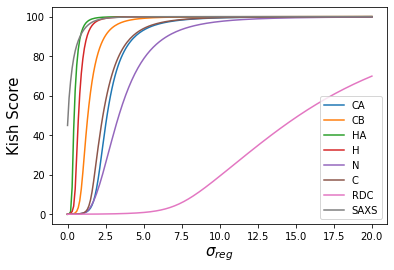

In [83]:
for key in KishScan:
 plt.plot(KishScan[key]['kish'][:,0],KishScan[key]['kish'][:,1],label='%s'%key)
plt.legend()
plt.xlabel(r'$\sigma_{reg}$',size=15)
plt.ylabel('Kish Score', size=15)
plt.savefig('%s/Kishscan.png'%outdir)
plt.show()

CA


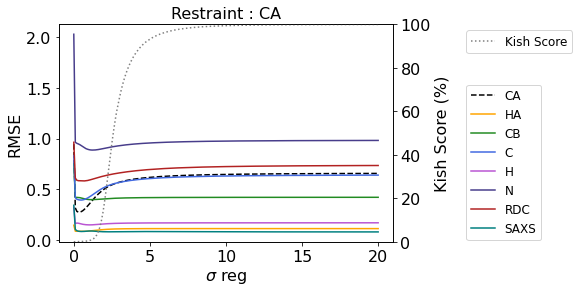

CB


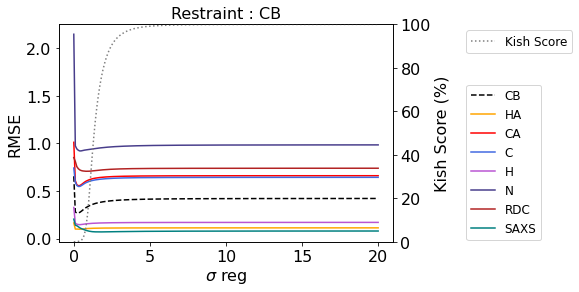

HA


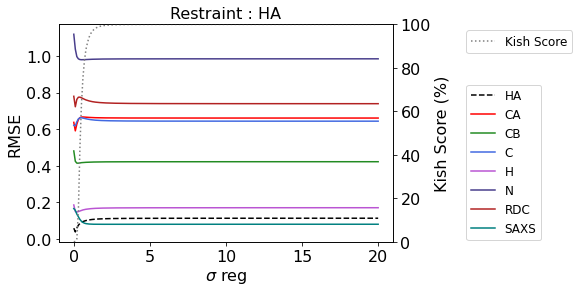

H


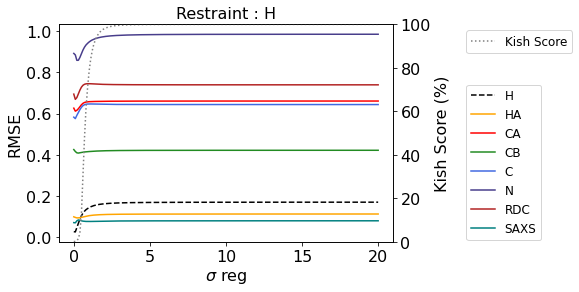

N


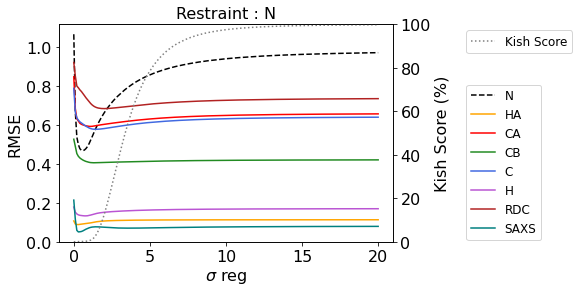

C


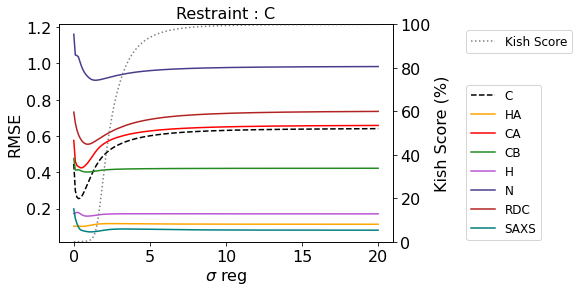

RDC


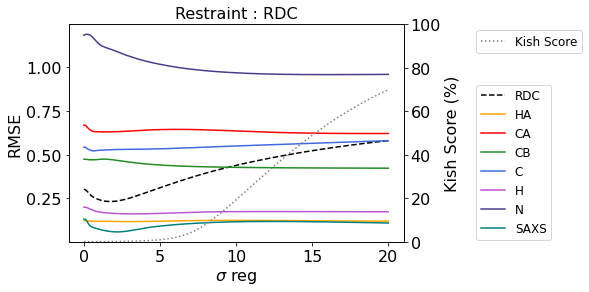

SAXS


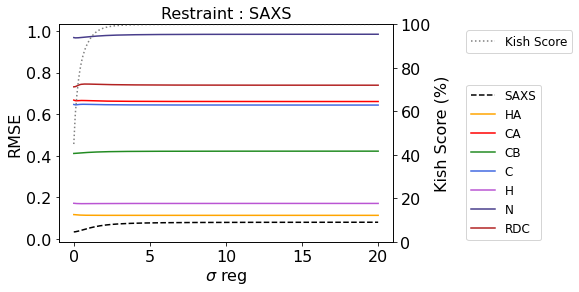

In [84]:
colors = {'C': 'royalblue','HA': 'orange', 'CA': 'red',  'CB': 'forestgreen', 'H': 'mediumorchid', 'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'RDC': 'firebrick', 'RDC_Q': 'firebrick', 'SAXS':'teal', 'Tot': 'black'}

for key in RMSE_dict:
   print(key)
   kish=[]
   theta=[]
   rmse_r=[]
   for i in RMSE_dict[key].keys():
    kish.append(RMSE_dict[key][i]['Kish'])
    theta.append(i)
    rmse_r.append(RMSE_dict[key][i]['r_f'][key])
   theta_rev=np.asarray(theta,dtype=float)[::-1]
   rmse_r_rev=np.asarray(rmse_r,dtype=float)[::-1]
   kish_rev=np.asarray(kish,dtype=float)[::-1]
   f, ax = plt.subplots()
   ax.plot(theta_rev,rmse_r_rev,label=key,c='black',linestyle='dashed')
   #keyslist=RMSE_dict[key][i]['v_f'].keys()
   #colors = [f"C{j}" for j in range(len(keys_list))]
   for key2 in RMSE_dict[key][i]['v_f'].keys():
     rmse_v=[]
     for k in RMSE_dict[key].keys():
      rmse_v.append(RMSE_dict[key][k]['v_f'][key2])
     rmse_v_rev=np.asarray(rmse_v,dtype=float)[::-1]
     ax.plot(theta_rev,rmse_v_rev,label=key2,color = colors[key2])
    
   ax.tick_params(labelsize=16)
   ax.legend(bbox_to_anchor=(1.2, 0.75), loc='upper left',fontsize = 12)
   ax.set_title(f"Restraint : {key}", size= 16)
   ax.set_xlabel("$\sigma$ reg", size = 16)
   ax.set_ylabel("RMSE", size=16)
        
   ax2 = ax.twinx()
   ax2.plot(theta_rev,kish_rev, color = 'grey', ls = 'dotted', label = 'Kish Score')
   #ax2.plot(theta_rev,kish_rev,'.', color = 'grey', ls = 'dotted', label = 'Kish Score', lw = 0.9, alpha = 0.8)
   ax2.set_ylabel("Kish Score (%)", size =16)
   ax2.set_ylim(0,100)
   ax2.legend(bbox_to_anchor = (1.2, 1.0), loc='upper left',fontsize = 12)
   ax2.tick_params(labelsize=16)
   plt.savefig('%s/%s.rmse_v_kish_v_sigma.png'%(outdir,key))
   
   plt.show()

In [112]:
err_d = { 'HA': 0.1,
          'CA': 0.2,
          'CB': 0.2,
          'C':  0.2,
          'H':  0.1,
          'HA2': 0.1,
          'HA3': 0.1,
          'N': 0.5 ,
          'RDC': 5.0 ,
          'Rg': 0.01,
          'PRE_2': 0.1,
          'PRE_59': 0.1,
          'SAXS': 0.003,
          'JHNHA': 0.25}


def plot_func(weights):   
    for t in Reweight_Data:
     if t!='Rg':
      print(t)
      resid=[]
      exp=[]
      calc=[]    
      err_fit=[]    
      err=err_d[t]
      for i,id in enumerate(compare_dict_r[t]): 
       resid.append(float(id))
       exp.append(compare_dict_r[t][id][0]) 
       err_fit.append(err)
      initial=np.trim_zeros(initial_obs_r*data_r_type[t])
      reweight=np.trim_zeros(final_obs_r*data_r_type[t])
      exp=np.trim_zeros(obs_exp_r*data_r_type[t])
      err=err_d[t]
      rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
      rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
      print("RMSD_initial:%6.3lf" %rmsd_i,"RMSD_final:%6.3lf"%rmsd_f)
      plt.clf()
      if t=='RDC':
       qi_initial,rms_initial,qf_initial,rms_f_initial,rdc_scale_i_initial,c=scale_rdc_Q(exp,initial)
       qi_reweight,rms_i_reweight,qf_reweight,rms_f_reweight,rdc_scale_i_reweight,c=scale_rdc_Q(exp,reweight)
       print("RMSD initial scale:%6.3lf" %rms_f_initial,"RMSD final scale:%6.3lf"%rms_f_reweight)
       print("Q initial scale:%6.3lf" %qf_initial,"Q final scale:%6.3lf"%qf_reweight)
      plt.scatter(np.asarray(resid),np.absolute(initial-exp),color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
      plt.scatter(np.asarray(resid),np.absolute(reweight-exp),color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
      plt.plot(np.asarray(resid),err_fit,color='black',label='Error Tolerance')
      plt.ylabel('|Calc - Exp|',size=18)
      plt.title('%s'%t,size='20')
      plt.xticks(fontsize=16)
      plt.yticks(fontsize=16)
      plt.xticks(size='18')
      plt.yticks(size='18')
      plt.xlabel('Residue',size=18)
      plt.legend(loc='upper right')
      plt.tight_layout()  
      plt.savefig('%s/%s.reweight.dev.png'%(CS_dir,t))
      #plt.show()
      plt.clf()
      plt.scatter(np.asarray(resid),initial,color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
      plt.scatter(np.asarray(resid),reweight,color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
      if t=='RDC':
       plt.scatter(np.asarray(resid),rdc_scale_i_reweight,color='blue',label="RMSD_scale:%6.3lf"%rms_f_reweight)
       plt.plot(np.asarray(resid),exp,color='black',label='Exp')
      plt.ylabel('|Calc - Exp|',size=18)
      plt.title('%s'%t,size='20')
      plt.xticks(fontsize=16)
      plt.yticks(fontsize=16)
      plt.xticks(size='18')
      plt.yticks(size='18')
      plt.xlabel('Residue',size=18)
      plt.legend(loc='upper right')
      plt.tight_layout() 
      plt.savefig('%s/%s.reweight.pdf'%(CS_dir,t))
      #plt.show()
    
    
      for t in Validation_Data:
         if t!='Rg':
          print(t)
          resid=[]
          exp=[]
          calc=[]    
          err_fit=[]    
          err=err_d[t]
          for i,id in enumerate(compare_dict_v[t]): 
           resid.append(float(id))
           exp.append(compare_dict_v[t][id][0]) 
           err_fit.append(err)
          initial=np.trim_zeros(initial_obs_v*data_v_type[t])
          reweight=np.trim_zeros(final_obs_v*data_v_type[t])
          exp=np.trim_zeros(obs_exp_v*data_v_type[t])
          err=err_d[t]
          rmsd_i=(sum(np.square(initial-exp))/len(exp))**0.5
          rmsd_f=(sum(np.square(reweight-exp))/len(exp))**0.5
          print("RMSD_initial:%6.3lf" %(sum(np.square(initial-exp))/len(exp))**0.5,"RMSD_final:%6.3lf"%(sum(np.square(reweight-exp))/len(exp))**0.5)
         if t=='RDC':
#            qi_i,rms_i_i,qf_i,rms_f_i,i_fit=scale_rdc_Q(exp,initial)   
#            qi_f,rms_f_f,qf_f,rms_f_f,f_fit=scale_rdc_Q(exp,reweight) 
            qi_initial,rms_initial,qf_initial,rms_f_initial,rdc_scale_i_initial,c=scale_rdc_Q(exp,initial)
            qi_reweight,rms_i_reweight,qf_reweight,rms_f_reweight,rdc_scale_i_reweight,c=scale_rdc_Q(exp,reweight)
            print("Q_inital:",qf_initial,"RMS_initial:",rms_f_initial,"Q_reweight:",qf_reweight,"RMS_reweight:",rms_f_reweight)  
         plt.clf()
         plt.scatter(np.asarray(resid),np.absolute(initial-exp),color='orange',marker='D',label="RMSD_initial:%6.3lf"%rmsd_i)   
         plt.scatter(np.asarray(resid),np.absolute(reweight-exp),color='purple',label="RMSD_final:%6.3lf"%rmsd_f)
         plt.plot(np.asarray(resid),err_fit,color='black',label='Error Tolerance')
         max_dev=max(np.absolute(initial-exp))
         plt.ylim(0,max_dev*1.5)
         plt.ylabel('|Calc - Exp|',size=18)
         plt.title('%s'%t,size='20')
         plt.xticks(fontsize=16)
         plt.yticks(fontsize=16)
         plt.xticks(size='18')
         plt.yticks(size='18')
         plt.xlabel('Residue',size=18)
         plt.legend(loc='upper right')
         plt.tight_layout() 
         plt.savefig('%s/%s.reweight.dev.val.pdf'%(CS_dir,t))
         #plt.show()       

Reweight Data = CA
2.11
CA
RMSD_initial: 0.661 RMSD_final: 0.514


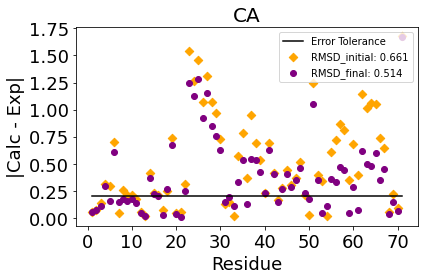

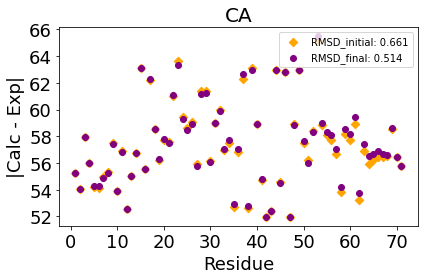

HA
RMSD_initial: 0.113 RMSD_final: 0.106


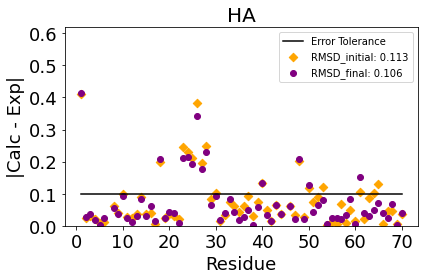

CB
RMSD_initial: 0.422 RMSD_final: 0.408


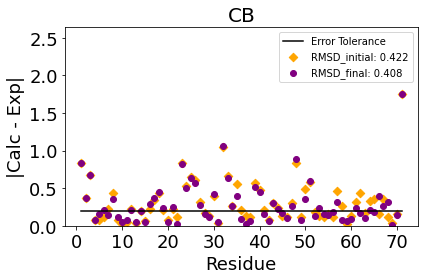

C
RMSD_initial: 0.644 RMSD_final: 0.527


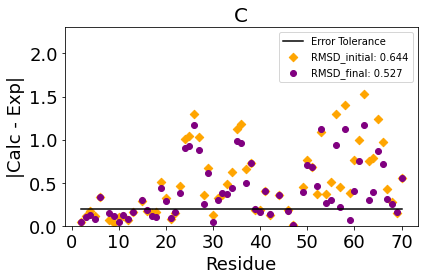

H
RMSD_initial: 0.171 RMSD_final: 0.161


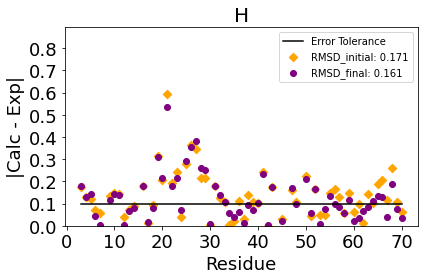

N
RMSD_initial: 0.985 RMSD_final: 0.907


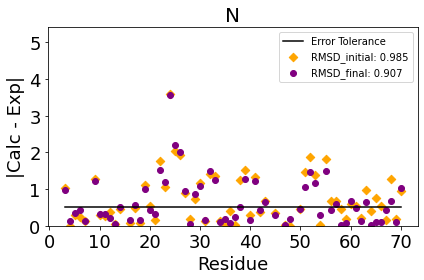

RDC
RMSD_initial: 4.087 RMSD_final: 3.553
Q_inital: 0.7393214860834824 RMS_initial: 4.087053535190892 Q_reweight: 0.6368281429614939 RMS_reweight: 3.520458639431356


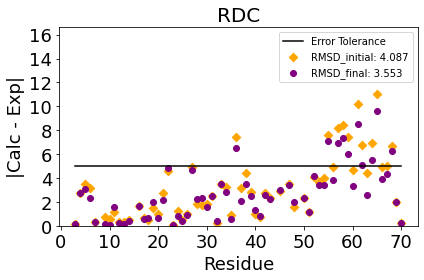

SAXS
RMSD_initial: 0.080 RMSD_final: 0.082


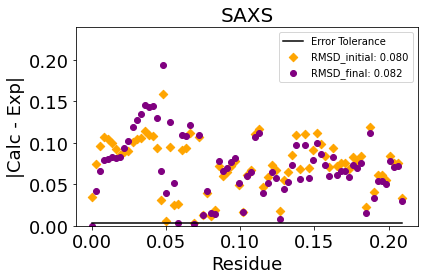

CA Theta: 2.1114472361809042 Kish: 23.013694 RMSD initail: 0.6609 RMSD final: 0.5139
Initial RMSE reweight data 
 * Total :      0.661
 *    CA :      0.661
Initial RMSE validation data
 * Total :      1.568
 *    HA :      0.113
 *    CB :      0.422
 *     C :      0.644
 *     H :      0.171
 *     N :      0.985
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.080
Final RMSE reweight data
 * Total :      0.514
 *    CA :      0.514
Final RMSE validation data
 * Total :      1.368
 *    HA :      0.106
 *    CB :      0.408
 *     C :      0.527
 *     H :      0.161
 *     N :      0.907
 *    RDC :      3.553
 *    RDC Q_scaled:  0.637
 *    SAXS :      0.082
Reweight Data = CB
1.01
CB
RMSD_initial: 0.422 RMSD_final: 0.345


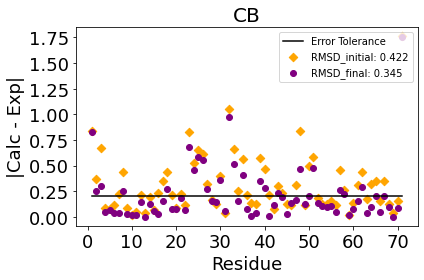

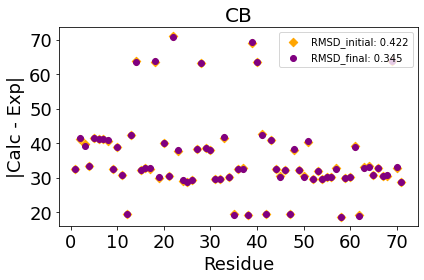

HA
RMSD_initial: 0.113 RMSD_final: 0.107


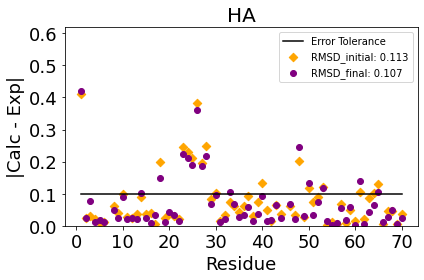

CA
RMSD_initial: 0.661 RMSD_final: 0.618


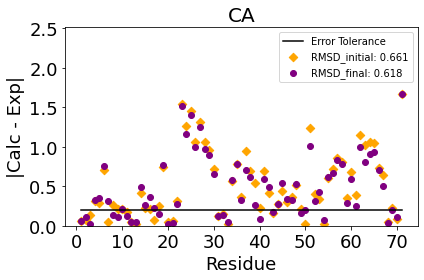

C
RMSD_initial: 0.644 RMSD_final: 0.601


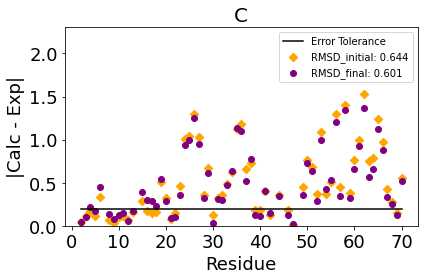

H
RMSD_initial: 0.171 RMSD_final: 0.158


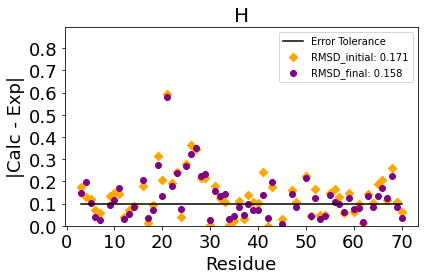

N
RMSD_initial: 0.985 RMSD_final: 0.936


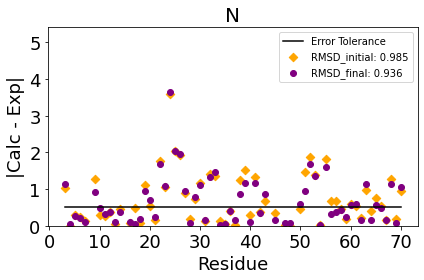

RDC
RMSD_initial: 4.087 RMSD_final: 3.917
Q_inital: 0.7393214860834824 RMS_initial: 4.087053535190892 Q_reweight: 0.707992604628221 RMS_reweight: 3.9138639037308316


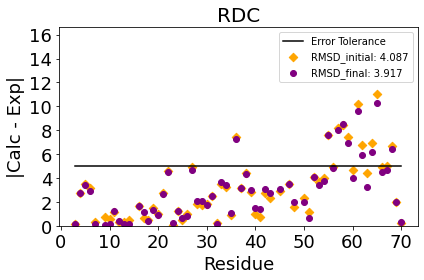

SAXS
RMSD_initial: 0.080 RMSD_final: 0.078


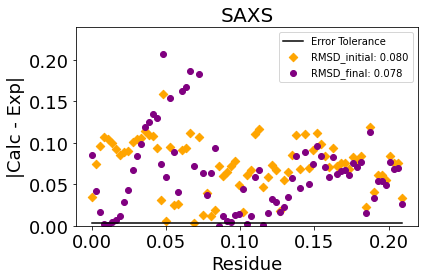

CB Theta: 1.005974874371859 Kish: 21.138335 RMSD initail: 0.4222 RMSD final: 0.3446
Initial RMSE reweight data 
 * Total :      0.422
 *    CB :      0.422
Initial RMSE validation data
 * Total :      1.581
 *    HA :      0.113
 *    CA :      0.661
 *     C :      0.644
 *     H :      0.171
 *     N :      0.985
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.080
Final RMSE reweight data
 * Total :      0.345
 *    CB :      0.345
Final RMSE validation data
 * Total :      1.512
 *    HA :      0.107
 *    CA :      0.618
 *     C :      0.601
 *     H :      0.158
 *     N :      0.936
 *    RDC :      3.917
 *    RDC Q_scaled:  0.708
 *    SAXS :      0.078
Reweight Data = HA
0.40
HA
RMSD_initial: 0.113 RMSD_final: 0.084


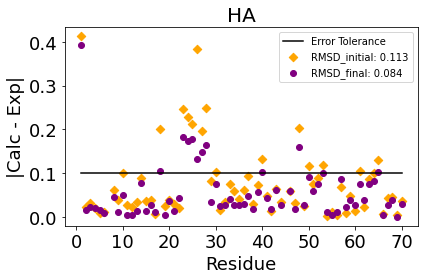

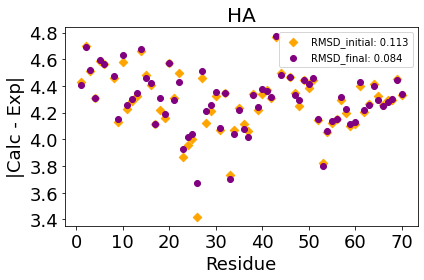

CA
RMSD_initial: 0.661 RMSD_final: 0.663


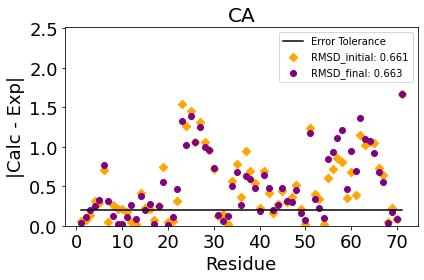

CB
RMSD_initial: 0.422 RMSD_final: 0.416


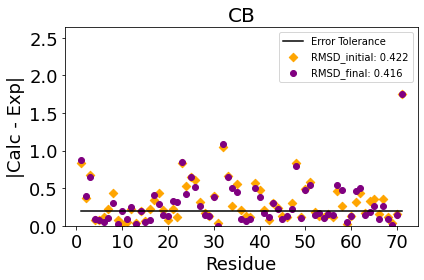

C
RMSD_initial: 0.644 RMSD_final: 0.662


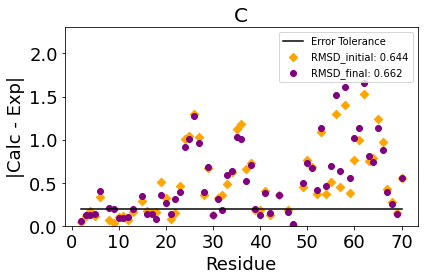

H
RMSD_initial: 0.171 RMSD_final: 0.153


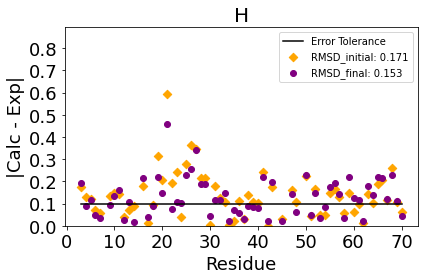

N
RMSD_initial: 0.985 RMSD_final: 0.981


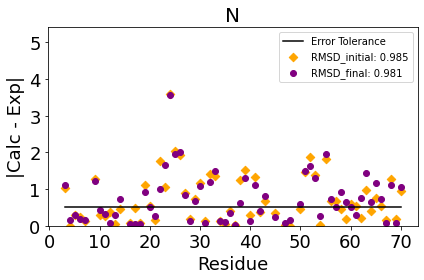

RDC
RMSD_initial: 4.087 RMSD_final: 4.286
Q_inital: 0.7393214860834821 RMS_initial: 4.087053535190891 Q_reweight: 0.7751794170259134 RMS_reweight: 4.285280269002258


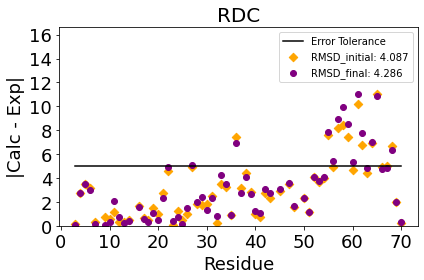

SAXS
RMSD_initial: 0.080 RMSD_final: 0.107


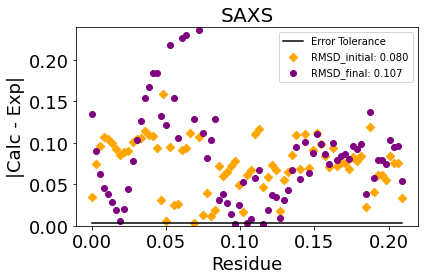

HA Theta: 0.4029899497487437 Kish: 42.718170 RMSD initail: 0.1133 RMSD final: 0.0842
Initial RMSE reweight data 
 * Total :      0.113
 *    HA :      0.113
Initial RMSE validation data
 * Total :      1.583
 *    CA :      0.661
 *    CB :      0.422
 *     C :      0.644
 *     H :      0.171
 *     N :      0.985
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.080
Final RMSE reweight data
 * Total :      0.084
 *    HA :      0.084
Final RMSE validation data
 * Total :      1.653
 *    CA :      0.663
 *    CB :      0.416
 *     C :      0.662
 *     H :      0.153
 *     N :      0.981
 *    RDC :      4.286
 *    RDC Q_scaled:  0.775
 *    SAXS :      0.107
Reweight Data = H
0.60
H
RMSD_initial: 0.171 RMSD_final: 0.117


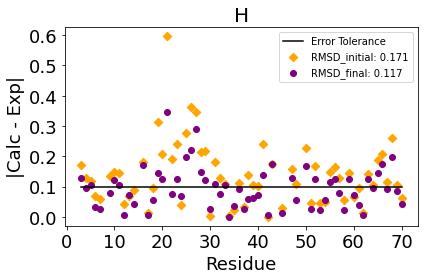

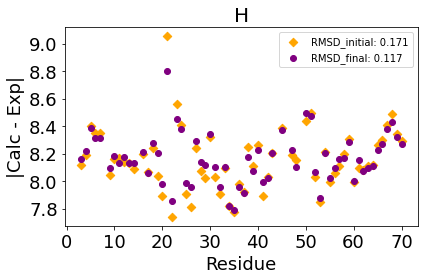

HA
RMSD_initial: 0.113 RMSD_final: 0.099


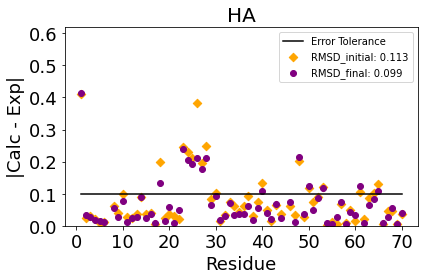

CA
RMSD_initial: 0.661 RMSD_final: 0.650


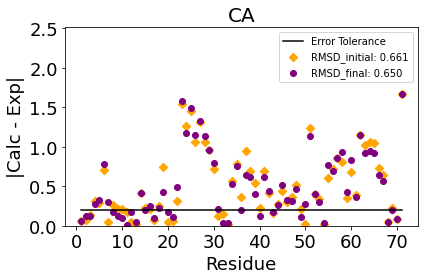

CB
RMSD_initial: 0.422 RMSD_final: 0.413


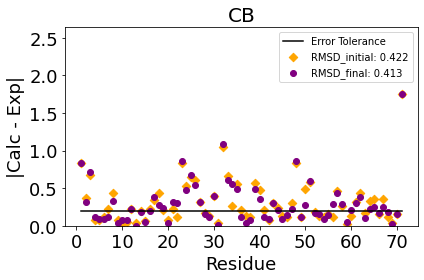

C
RMSD_initial: 0.644 RMSD_final: 0.638


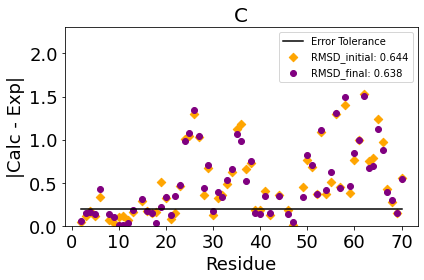

N
RMSD_initial: 0.985 RMSD_final: 0.908


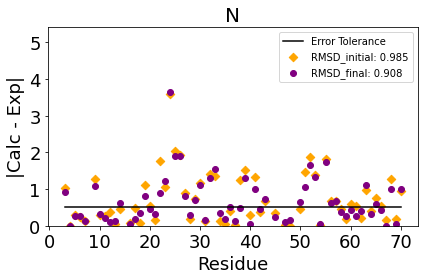

RDC
RMSD_initial: 4.087 RMSD_final: 4.075
Q_inital: 0.7393214860834821 RMS_initial: 4.087053535190892 Q_reweight: 0.7370358721209982 RMS_reweight: 4.074418400406784


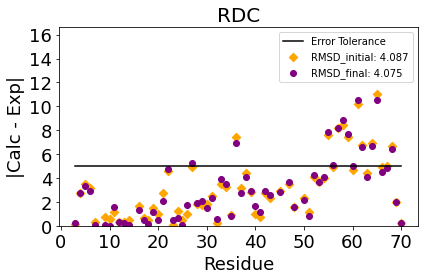

SAXS
RMSD_initial: 0.080 RMSD_final: 0.079


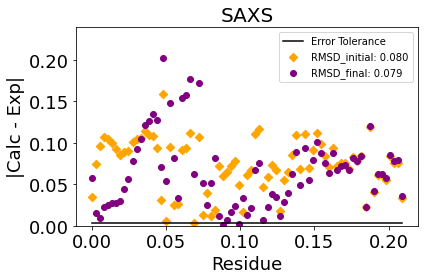

H Theta: 0.6039849246231156 Kish: 29.657173 RMSD initail: 0.1707 RMSD final: 0.1170
Initial RMSE reweight data 
 * Total :      0.171
 *     H :      0.171
Initial RMSE validation data
 * Total :      1.575
 *    HA :      0.113
 *    CA :      0.661
 *    CB :      0.422
 *     C :      0.644
 *     N :      0.985
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.080
Final RMSE reweight data
 * Total :      0.117
 *     H :      0.117
Final RMSE validation data
 * Total :      1.563
 *    HA :      0.099
 *    CA :      0.650
 *    CB :      0.413
 *     C :      0.638
 *     N :      0.908
 *    RDC :      4.075
 *    RDC Q_scaled:  0.737
 *    SAXS :      0.079
Reweight Data = N
2.31
N
RMSD_initial: 0.985 RMSD_final: 0.698


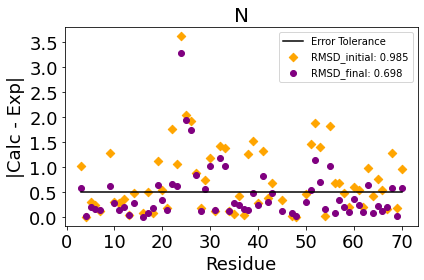

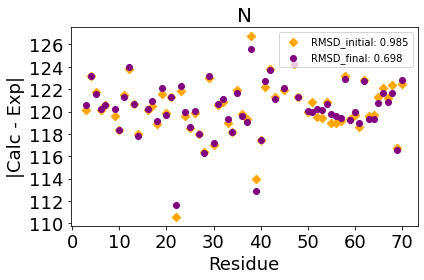

HA
RMSD_initial: 0.113 RMSD_final: 0.108


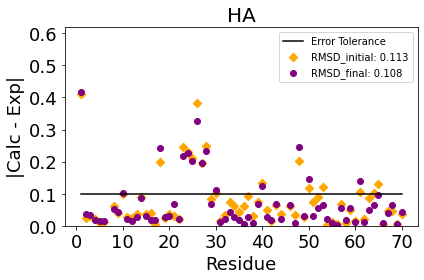

CA
RMSD_initial: 0.661 RMSD_final: 0.608


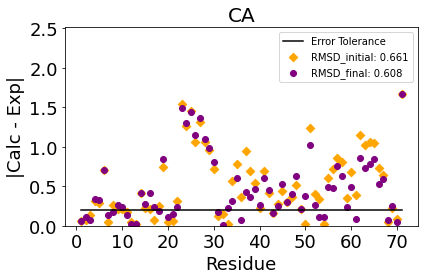

CB
RMSD_initial: 0.422 RMSD_final: 0.409


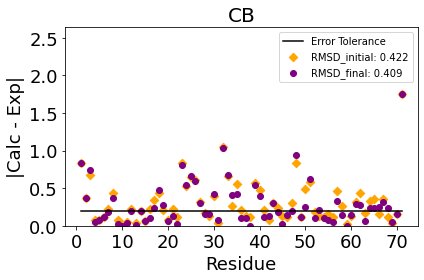

C
RMSD_initial: 0.644 RMSD_final: 0.586


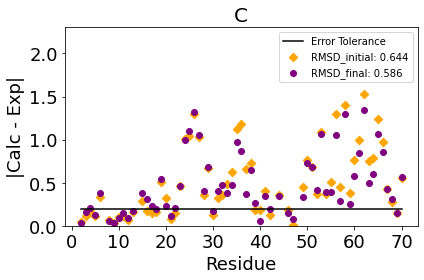

H
RMSD_initial: 0.171 RMSD_final: 0.154


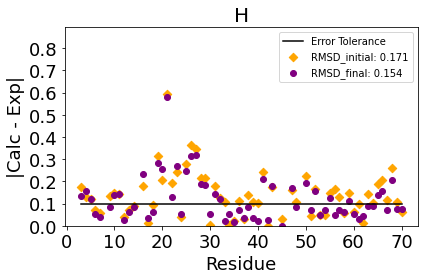

RDC
RMSD_initial: 4.087 RMSD_final: 3.797
Q_inital: 0.7393214860834821 RMS_initial: 4.087053535190892 Q_reweight: 0.6858886013469272 RMS_reweight: 3.791670451419232


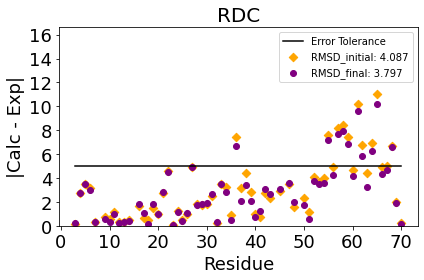

SAXS
RMSD_initial: 0.080 RMSD_final: 0.073


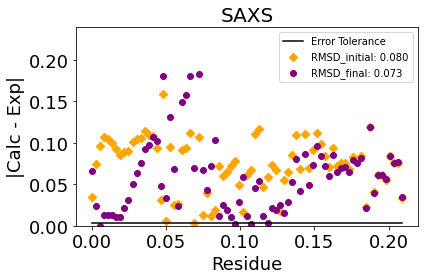

N Theta: 2.3124422110552763 Kish: 20.477555 RMSD initail: 0.9847 RMSD final: 0.6979
Initial RMSE reweight data 
 * Total :      0.985
 *     N :      0.985
Initial RMSE validation data
 * Total :      1.535
 *    HA :      0.113
 *    CA :      0.661
 *    CB :      0.422
 *     C :      0.644
 *     H :      0.171
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.080
Final RMSE reweight data
 * Total :      0.698
 *     N :      0.698
Final RMSE validation data
 * Total :      1.425
 *    HA :      0.108
 *    CA :      0.608
 *    CB :      0.409
 *     C :      0.586
 *     H :      0.154
 *    RDC :      3.797
 *    RDC Q_scaled:  0.686
 *    SAXS :      0.073
Reweight Data = C
1.81
C
RMSD_initial: 0.644 RMSD_final: 0.478


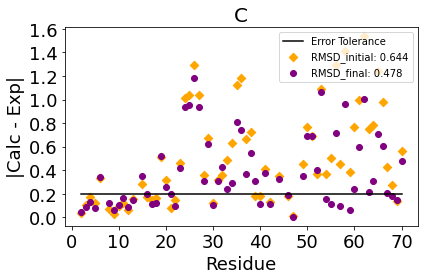

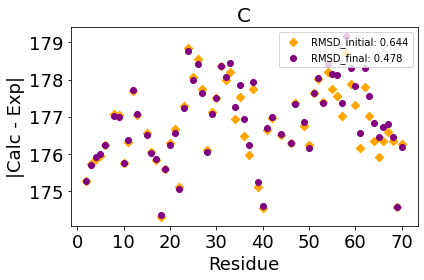

HA
RMSD_initial: 0.113 RMSD_final: 0.116


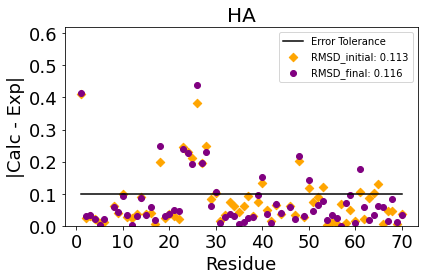

CA
RMSD_initial: 0.661 RMSD_final: 0.547


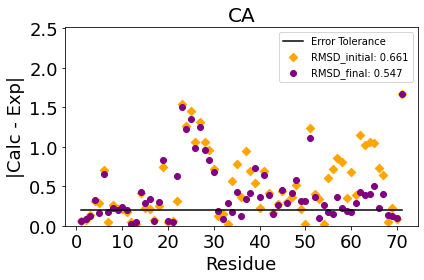

CB
RMSD_initial: 0.422 RMSD_final: 0.411


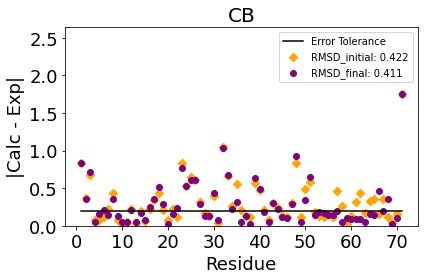

H
RMSD_initial: 0.171 RMSD_final: 0.167


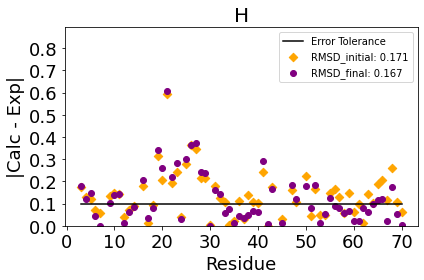

N
RMSD_initial: 0.985 RMSD_final: 0.912


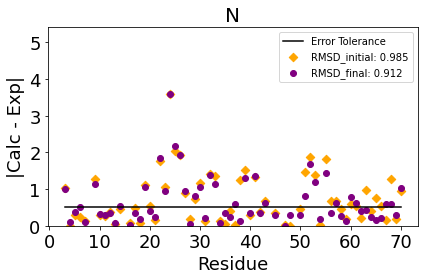

RDC
RMSD_initial: 4.087 RMSD_final: 3.315
Q_inital: 0.7393214860834821 RMS_initial: 4.087053535190891 Q_reweight: 0.5928138894156056 RMS_reweight: 3.2771428235926177


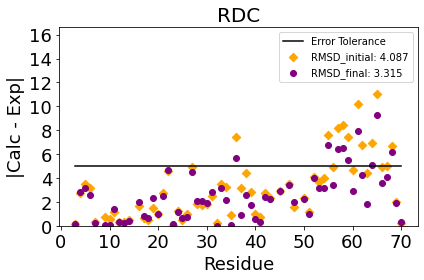

SAXS
RMSD_initial: 0.080 RMSD_final: 0.078


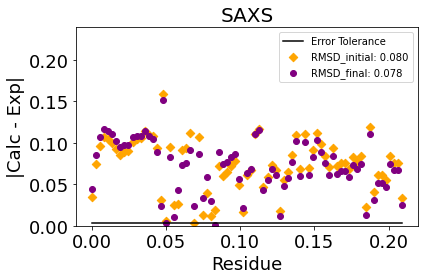

C Theta: 1.8099547738693464 Kish: 22.203480 RMSD initail: 0.6438 RMSD final: 0.4784
Initial RMSE reweight data 
 * Total :      0.644
 *     C :      0.644
Initial RMSE validation data
 * Total :      1.560
 *    HA :      0.113
 *    CA :      0.661
 *    CB :      0.422
 *     H :      0.171
 *     N :      0.985
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.080
Final RMSE reweight data
 * Total :      0.478
 *     C :      0.478
Final RMSE validation data
 * Total :      1.280
 *    HA :      0.116
 *    CA :      0.547
 *    CB :      0.411
 *     H :      0.167
 *     N :      0.912
 *    RDC :      3.315
 *    RDC Q_scaled:  0.593
 *    SAXS :      0.078
Reweight Data = RDC
10.15
RDC
RMSD_initial: 4.087 RMSD_final: 2.482
RMSD initial scale: 4.087 RMSD final scale: 2.444
Q initial scale: 0.739 Q final scale: 0.442


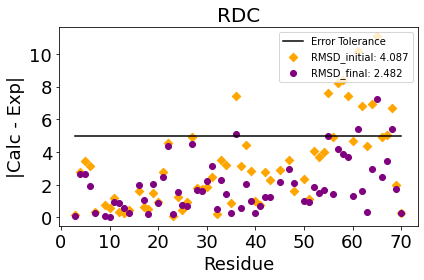

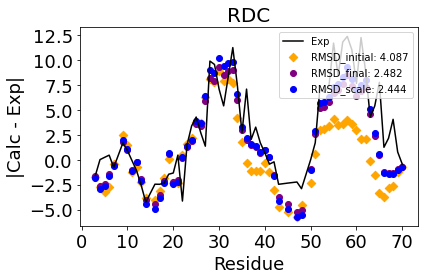

HA
RMSD_initial: 0.113 RMSD_final: 0.125


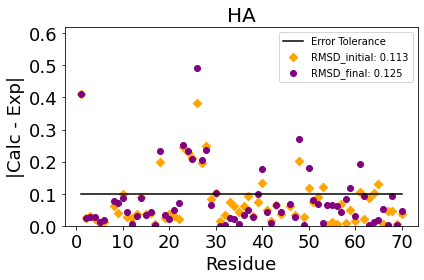

CA
RMSD_initial: 0.661 RMSD_final: 0.635


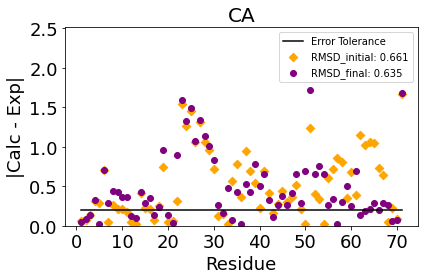

CB
RMSD_initial: 0.422 RMSD_final: 0.427


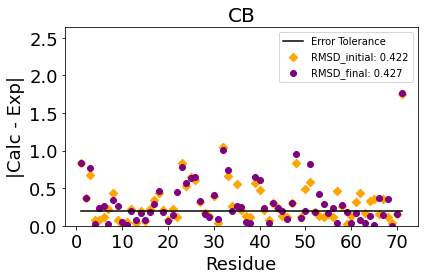

C
RMSD_initial: 0.644 RMSD_final: 0.550


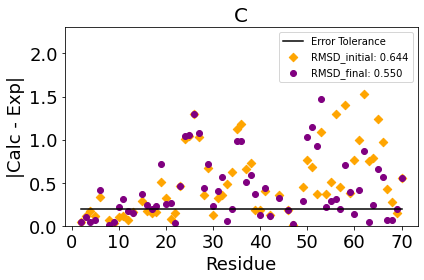

H
RMSD_initial: 0.171 RMSD_final: 0.175


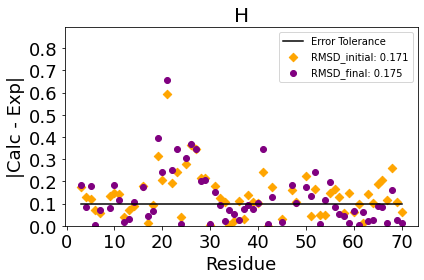

N
RMSD_initial: 0.985 RMSD_final: 0.967


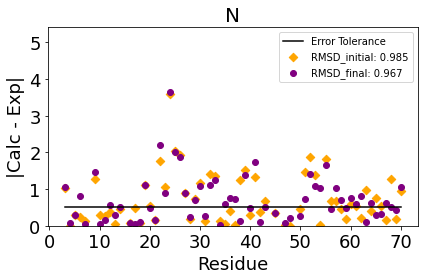

SAXS
RMSD_initial: 0.080 RMSD_final: 0.117


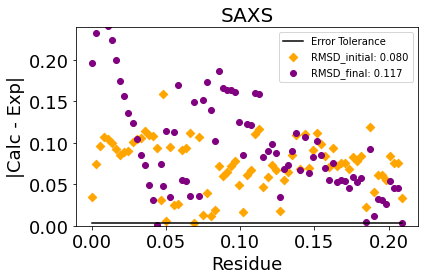

RDC Theta: 10.151246231155778 Kish: 20.247605 RMSD initail: 4.0871 RMSD final: 2.4822
Initial RMSE reweight data 
 * Total :      4.087
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
Initial RMSE validation data
 * Total :      0.530
 *    HA :      0.113
 *    CA :      0.661
 *    CB :      0.422
 *     C :      0.644
 *     H :      0.171
 *     N :      0.985
 *    SAXS :      0.080
Final RMSE reweight data
 * Total :      2.482
 *    RDC :      2.482
 *    RDC Q_scaled:  0.442
Final RMSE validation data
 * Total :      0.509
 *    HA :      0.125
 *    CA :      0.635
 *    CB :      0.427
 *     C :      0.550
 *     H :      0.175
 *     N :      0.967
 *    SAXS :      0.117
Reweight Data = SAXS
0.00
SAXS
RMSD_initial: 0.080 RMSD_final: 0.034


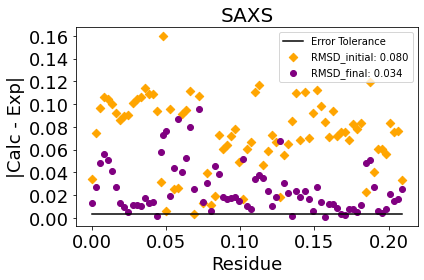

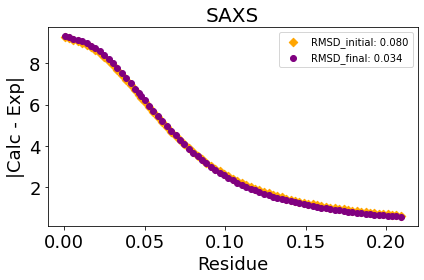

HA
RMSD_initial: 0.113 RMSD_final: 0.117


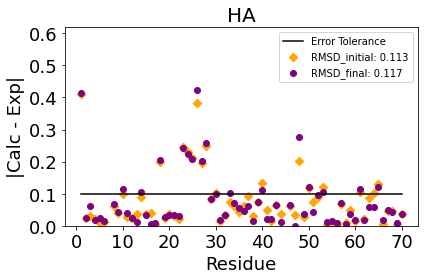

CA
RMSD_initial: 0.661 RMSD_final: 0.668


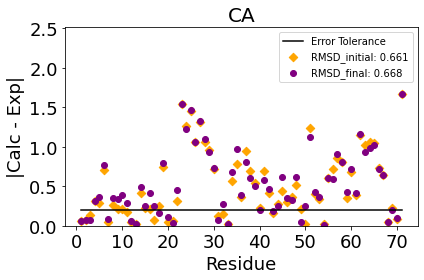

CB
RMSD_initial: 0.422 RMSD_final: 0.411


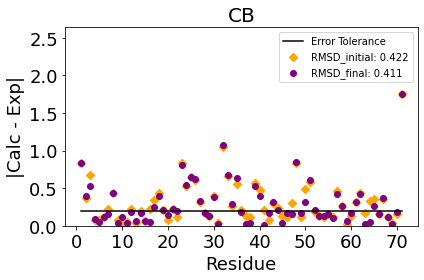

C
RMSD_initial: 0.644 RMSD_final: 0.647


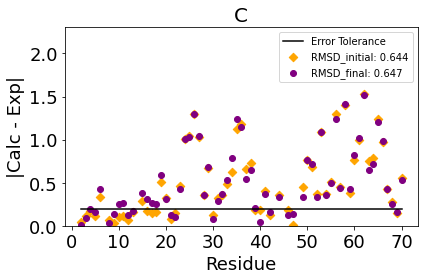

H
RMSD_initial: 0.171 RMSD_final: 0.171


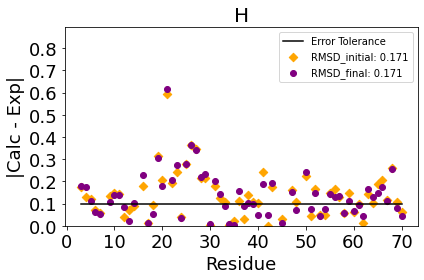

N
RMSD_initial: 0.985 RMSD_final: 0.968


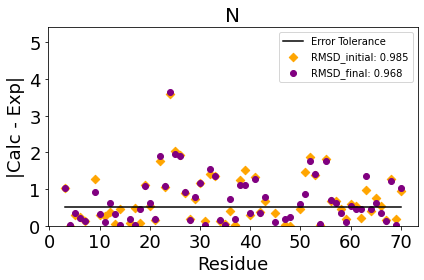

RDC
RMSD_initial: 4.087 RMSD_final: 4.044
Q_inital: 0.7393214860834822 RMS_initial: 4.087053535190892 Q_reweight: 0.7315859677514276 RMS_reweight: 4.044290707191614


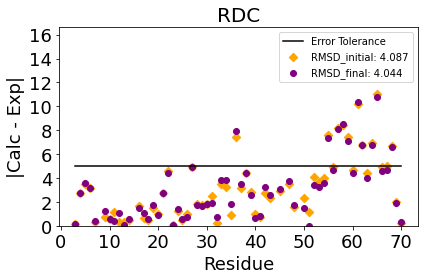

SAXS Theta: 0.001 Kish: 44.949762 RMSD initail: 0.0804 RMSD final: 0.0335
Initial RMSE reweight data 
 * Total :      0.080
 *    SAXS :      0.080
Initial RMSE validation data
 * Total :      1.601
 *    HA :      0.113
 *    CA :      0.661
 *    CB :      0.422
 *     C :      0.644
 *     H :      0.171
 *     N :      0.985
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
Final RMSE reweight data
 * Total :      0.034
 *    SAXS :      0.034
Final RMSE validation data
 * Total :      1.585
 *    HA :      0.117
 *    CA :      0.668
 *    CB :      0.411
 *     C :      0.647
 *     H :      0.171
 *     N :      0.968
 *    RDC :      4.044
 *    RDC Q_scaled:  0.732


In [88]:
To_Scan=reweighting_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)      
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(outdir,CS) 
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    
    compare=[]
    compare_dict_r = { key: {} for key in compdata.keys()}
    compare_dict_v = { key: {} for key in compdata.keys()}
    
    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0, sd,compare_dict_v)
    
    
    theta_m = theta_dict[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg=theta_m
    sigma_md=sigma_md_r
    
    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)
    
    
    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias=np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights/=np.sum(initial_weights)
        initial_obs_r=np.dot(traj_r,initial_weights)
        initial_obs_r
        exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
        calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
        qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)    
        qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
        
        if(qf_neg<qf_pos):
            c=-c_neg
        else:
            c = c_pos
        RDC_rows=np.where(data_r_type['RDC']==1)
        traj_r[RDC_rows]=traj_r[RDC_rows]*c
        
    
    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights/=np.sum(initial_weights)
        initial_obs_v=np.dot(traj_v,initial_weights)
        initial_obs_v
        exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
        calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
        qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)    
        qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
        
        if(qf_neg<qf_pos):
            c=-c_neg
        else:
            c = c_pos
        RDC_rows=np.where(data_v_type['RDC']==1)
        traj_v[RDC_rows]=traj_v[RDC_rows]*c
        
    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r=np.dot(traj_r,initial_weights)
    initial_obs_v=np.dot(traj_v,initial_weights)
      #if res.success: print("\nMinimization worked: {}\n".format(res.success))
      #else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
    final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
      # e) final average observables for reweighting and validation
    final_obs_r=np.dot(traj_r,final_weights)
    final_obs_v=np.dot(traj_v,final_weights)
      # g) calculating Kish effective size
    Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
    Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
      #print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
      #print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
    Kish_ratio = (Ks_a/Ks_b)*100
    RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
    RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))
    
    
    plot_func(final_weights)
    
    print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
    
    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))
    
    for t in data_r_type:
        print(" *    %2s :" % t, end = '')
        print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))

        if str(t)=='RDC': 
          qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
          #print(" *    RDC scaled RMSD:", end = '')
          #print(" %6.3lf" % rms_f)
          print(" *    RDC scaled Q:", end = '')
          print(" %6.3lf" % qf)
        
    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))
    
    
    for t in data_v_type:
        print(" *    %2s :" % t, end= '')
        #(initial_obs_v-obs_exp_v)**2*data_v_type[t])
        print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
        if str(t)=='RDC': 
          qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
          #print(" *    RDC scaled RMSD:", end = '')
          #print(" %6.3lf" % rms_f)
          print(" *    RDC scaled Q:", end = '')
          print(" %6.3lf" % qf)
        
    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))
    
    
    for t in data_r_type:
        print(" *    %2s :" % t, end = '')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
        if str(t)=='RDC': 
          qi,rms_i,qf,rms_f,rdcs_scale_f,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
          #print(" *    RDC RMSE_scale:", end = '')
          #print(" %6.3lf" % rms_f)
          print(" *    RDC Q_scaled:", end = '')
          print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end = '')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
        if str(t)=='RDC': 
          qi,rms_i,qf,rms_f,rdc_scale_f,c=scale_rdc_Q(final_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
          #print(" *    RDC RMSE_scale:", end = '')
          #print(" %6.3lf" % rms_f)
          print(" *    RDC Q_scaled:", end = '')
          print(" %6.3lf" % qf)
    np.savetxt('%s/weights_final.dat'%(CS_dir),final_weights,fmt=" %6.12lf")
    # print final weights to file

    f=open("%s/weights_final.a.dat"%CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()                

In [89]:
combined_reweighting_keys = [reweighting_keys]
print('Reweighting keys: {}'.format(combined_reweighting_keys))

To_Scan=combined_reweighting_keys
thetas=np.linspace(0.01,5,20)
ref_theta=thetas[-1]
RMSE_dict_combined = {}
KishScan={}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan[CS]={}
    CS_dir=join(outdir, CS) 
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    print('Reweight Data = {}'.format(CS))
    RMSE_dict_combined[CS]={}
    combined_key_string=CS

    ### debugging variables
    compare=[]
    compare_dict_r = { key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure


    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    # THETA CYCLE
    theta_list=[]
    kish_list=[]
    rmsd_f_list=[]
    for theta_m in np.flip(thetas):
      
      s = '{:.2f}'.format(theta_m)
      print(s)
      sigma_reg=theta_m*err_r
      sigma_md=sigma_md_r
      RMSE_dict_combined[CS][s]={}

      # iv) Print dimensions
      nobs_r = len(obs_exp_r)
      nobs_v = len(obs_exp_v)
      #Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

      # v) perform minimization
      # OBS: res.X = lagrange multiplier
      weight_bias=np.ones(nframes)
      if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc) 
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
 

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c

        
      res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
      initial_weights = Normalize_Weights(weight_bias)
      initial_obs_r=np.dot(traj_r,initial_weights)
      #if res.success: print("\nMinimization worked: {}\n".format(res.success))
      #else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
      final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
      # e) final average observables for reweighting and validation
      final_obs_r=np.dot(traj_r,final_weights)

      # g) calculating Kish effective size
      Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
      Ks_a = np.average(final_weights)**2/np.average(final_weights**2)

    
      Kish_ratio = (Ks_a/Ks_b)*100
      RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
      RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))
      #print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
      theta_list.append(theta_m)
      kish_list.append(Kish_ratio)  
      rmsd_f_list.append(RMSE_reweight)
      RMSE_r_i={}
      RMSE_r_f={}
      RMSE_r_i['Tot']=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
        
      for t in data_r_type:
       RMSE_r_i[t]=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_i['RDC']=qf


        
      RMSE_r_f['Tot']=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))
      for t in data_r_type:
       RMSE_r_f[t]=np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_f['RDC']=qf
        
      RMSE_dict_combined[CS][s]['Kish']=Kish_ratio
      RMSE_dict_combined[CS][s]['r_i']=RMSE_r_i
      RMSE_dict_combined[CS][s]['r_f']=RMSE_r_f
    KishScan[CS]['kish']=np.column_stack((theta_list,kish_list))
    KishScan[CS]['rmsd']=np.column_stack((theta_list,rmsd_f_list))

Reweighting keys: [['CA', 'CB', 'HA', 'H', 'N', 'C', 'RDC', 'SAXS']]
Reweight Data = CA-CB-HA-H-N-C-RDC-SAXS
5.00
4.74
4.47
4.21
3.95
3.69
3.42
3.16
2.90
2.64
2.37
2.11
1.85
1.59
1.32
1.06
0.80
0.54
0.27
0.01


In [90]:
kish_min = 20
theta_dict_combined = {}
Kish_ratio_vals = []
for key in KishScan:
    k = KishScan[key]['kish']
    b = (np.where(k[:,1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m==0):
     theta_m = k[idy][0]
    theta_dict_combined[key]={}
    theta_dict_combined[key]=(theta_m)
    print(key, theta_m)

CA-CB-HA-H-N-C-RDC-SAXS 2.6363157894736844


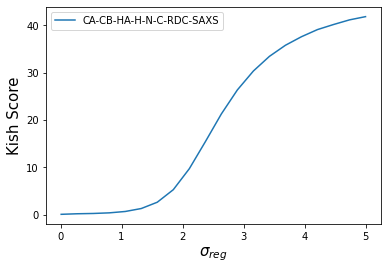

In [91]:
for key in KishScan:
 plt.plot(KishScan[combined_key_string]['kish'][:,0],KishScan[combined_key_string]['kish'][:,1],label='%s'%key)
plt.legend()
plt.xlabel(r'$\sigma_{reg}$',size=15)
plt.ylabel('Kish Score', size=15)
plt.savefig('%s/Kishscan.combined.pdf'%outdir)
plt.show()

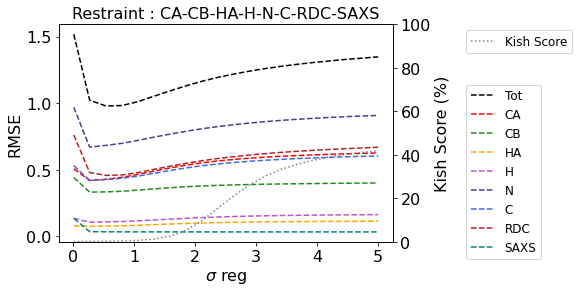

In [92]:
kish=[]
theta=[]
rmse_r=[]
for i in RMSE_dict_combined[combined_key_string].keys():
    kish.append(RMSE_dict_combined[combined_key_string][i]['Kish'])
    theta.append(i)
theta_rev=np.asarray(theta,dtype=float)[::-1]
kish_rev=np.asarray(kish,dtype=float)[::-1]
f, ax = plt.subplots()
for key2 in RMSE_dict_combined[combined_key_string][i]['r_f'].keys():
     rmse_r=[]
     for k in RMSE_dict_combined[combined_key_string].keys():
      rmse_r.append(RMSE_dict_combined[combined_key_string][k]['r_f'][key2])
     rmse_r_rev=np.asarray(rmse_r,dtype=float)[::-1]
     ax.plot(theta_rev,rmse_r_rev,label=key2,color = colors[key2],linestyle='dashed')
    
    
ax.tick_params(labelsize=16)
ax.legend(bbox_to_anchor=(1.2, 0.75), loc='upper left',fontsize = 12)
ax.set_title(f"Restraint : {combined_key_string}", size= 16)
ax.set_xlabel("$\sigma$ reg", size = 16)
ax.set_ylabel("RMSE", size=16)
        
ax2 = ax.twinx()
ax2.plot(theta_rev,kish_rev, color = 'grey', ls = 'dotted', label = 'Kish Score')
#ax2.plot(theta_rev,kish_rev,'.', color = 'grey', ls = 'dotted', label = 'Kish Score', lw = 0.9, alpha = 0.8)
ax2.set_ylabel("Kish Score (%)", size =16)
ax2.set_ylim(0,100)
ax2.legend(bbox_to_anchor = (1.2, 1.0), loc='upper left',fontsize = 12)
ax2.tick_params(labelsize=16)
plt.savefig('%s/%s.rmse_v_kish_v_sigma.pdf'%(outdir,key))

plt.show()

In [93]:
To_Scan=combined_reweighting_keys


CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


s = '{:.2f}'.format(theta_m)

sigma_reg=theta_m*err_r
# print(sigma_reg)
sigma_md=sigma_md_r
        

nobs_r = len(obs_exp_r)
nobs_v = len(obs_exp_v)
weight_bias=np.ones(nframes)
if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
initial_weights = Normalize_Weights(weight_bias)
initial_obs_r=np.dot(traj_r,initial_weights)
final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
final_obs_r=np.dot(traj_r,final_weights)
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
Kish_ratio = (Ks_a/Ks_b)*100
RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)

#Iniitial RMSE and Sigma 
print("Initial RMSE reweight data ")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))

    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
      #print(" *    RDC scaled RMSD:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC scaled Q:", end = '')
      print(" %6.3lf" % qf)
    
    
print("Final RMSE reweight data")
print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))

for t in data_r_type:
    print(" *    %2s :" % t, end = '')
    print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
    if str(t)=='RDC': 
      qi,rms_i,qf,rms_f,rdcs_scale_f,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
      #print(" *    RDC RMSE_scale:", end = '')
      #print(" %6.3lf" % rms_f)
      print(" *    RDC Q_scaled:", end = '')
      print(" %6.3lf" % qf)

np.savetxt('%s/weights_final.dat'%(CS_dir),final_weights,fmt=" %6.12lf")
# print final weights to file

f=open("%s/weights_final.a.dat"%CS_dir, "w")
for w in final_weights:
    f.write("%e\n" % w)
f.close()

CA-CB-HA-H-N-C-RDC-SAXS Theta: 2.6363157894736844 Kish: 21.258838 RMSD initail: 1.4811 RMSD final: 1.2196
Initial RMSE reweight data 
 * Total :      1.481
 *    CA :      0.661
 *    CB :      0.422
 *    HA :      0.113
 *     H :      0.171
 *     N :      0.985
 *     C :      0.644
 *    RDC :      4.087
 *    RDC scaled Q:  0.739
 *    SAXS :      0.080
Final RMSE reweight data
 * Total :      1.220
 *    CA :      0.578
 *    CB :      0.387
 *    HA :      0.106
 *     H :      0.149
 *     N :      0.839
 *     C :      0.555
 *    RDC :      3.343
 *    RDC Q_scaled:  0.599
 *    SAXS :      0.034


In [94]:
keys = list(theta_dict.keys())
keys2 = list(np.round(np.array(list(theta_dict.values())),2))
keys2 = ["{:.2f}".format(value) for value in keys2]
dfs = []
columns = "initial,final".split(',')
for k,k2 in zip(keys,keys2):
    if k2 == "0.0":k2 += "0"
    data = []
    index = []
    index.append(k)
    data.append([RMSE_dict[k][k2][i][k] for i in "r_i,r_f".split(",")])
    for k3 in keys:
        if k3 != k:
            data.append([RMSE_dict[k][k2][i][k3] for i in "v_i,v_f".split(",")])
            index.append(k3)
    l = np.array(data)
    index = np.array(index)
    df = pd.DataFrame(data=l, index=index, columns = columns)
    dfs.append(df)
df_dict = dict(zip(keys,dfs))

In [95]:
keys = list(theta_dict_combined.keys())
keys2 = list(np.round(np.array(list(theta_dict_combined.values())),2))
keys2 = ["{:.2f}".format(value) for value in keys2]
keys3 = list(theta_dict.keys())
dfs = []
columns = "initial,final".split(',')
for k,k2,k3 in zip(keys,keys2,keys3):
    if k2 == "0.0":k2 += "0"
    data = []
    index = []
    for k3 in keys3:
        data.append([RMSE_dict_combined[k][k2][i][k3] for i in "r_i,r_f".split(",")])
        index.append(k3)
        
    l = np.array(data)
    index = np.array(index)
    df = pd.DataFrame(data=l, index=index, columns = columns)
    dfs.append(df)
df_dict_combined = dict(zip(keys,dfs))

In [96]:
combined_key_string

'CA-CB-HA-H-N-C-RDC-SAXS'

In [97]:
def subframe(df,key,key2):
    df_key = df_dict[key].assign(Unbiased_MD= df_dict[key][key2].round(3)) 
    df_key = df_key.drop(columns = ['initial','final'])
    df_key = df_key.T[reweighting_keys].round(3)
    return df_key

def subframe_combined(df,key,key2):
    df_key = df_dict_combined[key].assign(all_data= df_dict_combined[key][key2].round(3)) 
    df_key = df_key.drop(columns = ['initial','final'])
    df_key = df_key.T[reweighting_keys].round(3)
    return df_key

subframes_only_initial = subframe(df_dict['CA'],'CA','initial')
subframes_combined = subframe_combined(df_dict_combined[combined_key_string],combined_key_string,'final')

In [98]:
subframes_final = pd.concat([subframe(df_dict,i,'final') for i in reweighting_keys])
subframes_final.index = subframes_final.columns

In [99]:
table = pd.concat([subframes_only_initial, subframes_combined, subframes_final])

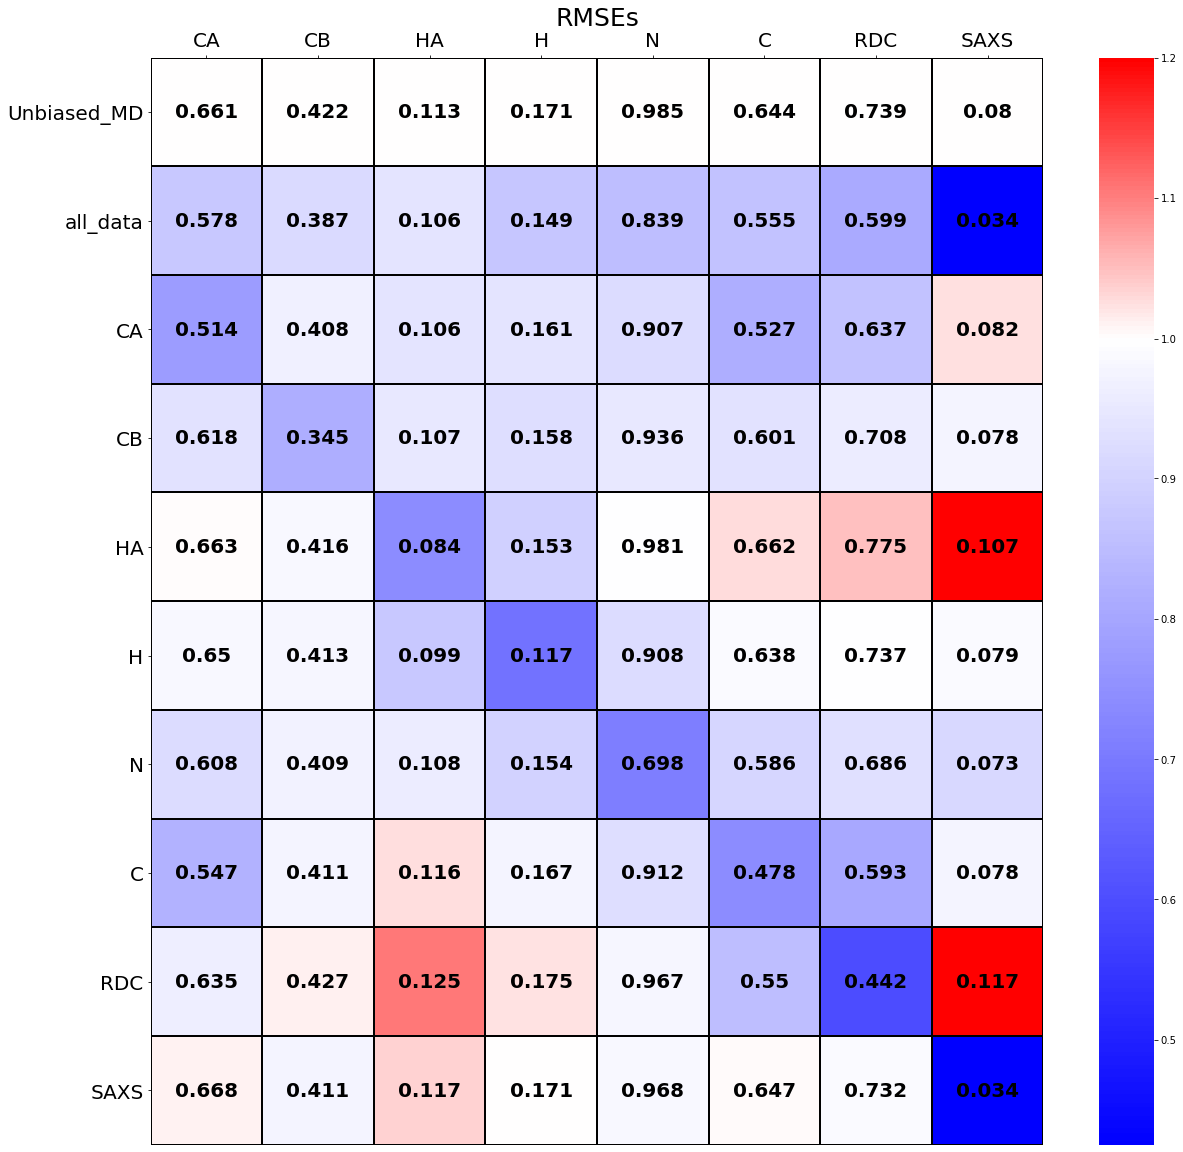

In [100]:
import matplotlib
import seaborn as sns
def plot_mat(df,title,unit,cbarlabel,
                   textsize,textcolor,cmap):
        """mat = square matrix
        unit = string specifying the units"""
        #ratio = emat/mat
        mat = df.to_numpy()
        ratio = mat/mat[0,:]
        divnorm=matplotlib.colors.TwoSlopeNorm(vmin=ratio.min(), vcenter=1., vmax=1.2)
        fig,ax = plt.subplots(1,figsize=(20,20))
        s = sns.heatmap(pd.DataFrame(ratio,index=table.index, columns = table.columns),linewidths=1,
                        linecolor='black', cmap=cmap,norm=divnorm,ax=ax)
        #s = ax.imshow(ratio, cmap=cmap)
        for i in range(len(mat)):
            for j in range(mat.shape[1]):
                c = mat[i,j]
                ax.text(j+.5,i+.5,f"{np.round(c,3)}{unit}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax.tick_params(labelsize=20,top=True)
        ax.tick_params(axis="y",rotation=0)
#         cb = plt.colorbar(s,label=cbarlabel,fraction=0.046,pad=0.04)
#         cb.set_label(cbarlabel, size=40)
#         cb.ax.tick_params(labelsize=30)
        ax.set_title(title, size = 25)
        ax.xaxis.tick_top()
        ax.grid(b=True,which='minor',color='black', linestyle='-', linewidth=1, alpha=0.2)
        #plt.minorticks_on()
        
        plt.savefig('%s/RMSE_TABLE_INITIAL_FINAL.pdf'%outdir)
        plt.show()
        return
plot_mat(table,"RMSEs", "","final / initial",20,"black","bwr")

In [101]:
new_rwt_keys = []
for i in range(len(reweighting_keys)):
    new_list = reweighting_keys.copy()
    del new_list[i]
    new_rwt_keys.append(new_list)

In [102]:
To_Scan= new_rwt_keys
thetas=np.linspace(0.01,5,20)
ref_theta=thetas[-1]
RMSE_leave_one_dict = {}
KishScan={}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan[CS]={}        
    print('Reweight Data = {}'.format(CS))
    RMSE_leave_one_dict[CS]={}


    ### debugging variables
    compare=[]
    compare_dict_r = { key: {} for key in compdata.keys()}
    compare_dict_v = { key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure


    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0, sd,compare_dict_v)

    # THETA CYCLE
    theta_list=[]
    kish_list=[]
    rmsd_f_list=[]
    for theta_m in np.flip(thetas):
      
      s = '{:.2f}'.format(theta_m)
      #print(s)
      sigma_reg=theta_m*err_r
      sigma_md=sigma_md_r
      RMSE_leave_one_dict[CS][s]={}

      # iv) Print dimensions
      nobs_r = len(obs_exp_r)
      nobs_v = len(obs_exp_v)
      #Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

      # v) perform minimization
      # OBS: res.X = lagrange multiplier
      weight_bias=np.ones(nframes)
    
      if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
        
       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


      if 'RDC' in Validation_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_v=np.dot(traj_v,initial_weights)
       exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_v_type['RDC']==1)
       traj_v[RDC_rows]=traj_v[RDC_rows]*c

      res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
      initial_weights = Normalize_Weights(weight_bias)
      initial_obs_r=np.dot(traj_r,initial_weights)
      initial_obs_v=np.dot(traj_v,initial_weights)

      final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
      final_obs_r=np.dot(traj_r,final_weights)
      final_obs_v=np.dot(traj_v,final_weights)
      # g) calculating Kish effective size
      Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
      Ks_a = np.average(final_weights)**2/np.average(final_weights**2)

      Kish_ratio = (Ks_a/Ks_b)*100
      RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
      RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

      theta_list.append(theta_m)
      kish_list.append(Kish_ratio)  
      rmsd_f_list.append(RMSE_reweight)
      RMSE_r_i={}
      RMSE_v_i={}
      RMSE_r_f={}
      RMSE_v_f={}
      RMSE_r_i['Tot']=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
        
      for t in data_r_type:
       RMSE_r_i[t]=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_i['RDC']=qf
        
      RMSE_v_i['Tot']=np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
      for t in data_v_type:
       RMSE_v_i[t]=np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
        RMSE_v_i['RDC']=qf        
        
      RMSE_r_f['Tot']=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

      for t in data_r_type:
       RMSE_r_f[t]=np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
        RMSE_r_f['RDC']=qf
        
      for t in data_v_type:
       RMSE_v_f[t]=np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t]))
       if str(t)=='RDC': 
        qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(final_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
        RMSE_v_f['RDC']=qf
        
      RMSE_leave_one_dict[CS][s]['Kish']=Kish_ratio
      RMSE_leave_one_dict[CS][s]['r_i']=RMSE_r_i
      RMSE_leave_one_dict[CS][s]['r_f']=RMSE_r_f
      RMSE_leave_one_dict[CS][s]['v_i']=RMSE_v_i
      RMSE_leave_one_dict[CS][s]['v_f']=RMSE_v_f
    
    KishScan[CS]['kish']=np.column_stack((theta_list,kish_list))
    KishScan[CS]['rmsd']=np.column_stack((theta_list,rmsd_f_list))

Reweight Data = CB-HA-H-N-C-RDC-SAXS
Reweight Data = CA-HA-H-N-C-RDC-SAXS
Reweight Data = CA-CB-H-N-C-RDC-SAXS
Reweight Data = CA-CB-HA-N-C-RDC-SAXS
Reweight Data = CA-CB-HA-H-C-RDC-SAXS
Reweight Data = CA-CB-HA-H-N-RDC-SAXS
Reweight Data = CA-CB-HA-H-N-C-SAXS
Reweight Data = CA-CB-HA-H-N-C-RDC


In [103]:
kish_min = 20
theta_dict_leave_one = {}
Kish_ratio_vals = []
for key in KishScan:
    k = KishScan[key]['kish']
    b = (np.where(k[:,1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m==0):
     theta_m = k[idy][0]
    theta_dict_leave_one[key]={}
    theta_dict_leave_one[key]=(theta_m)

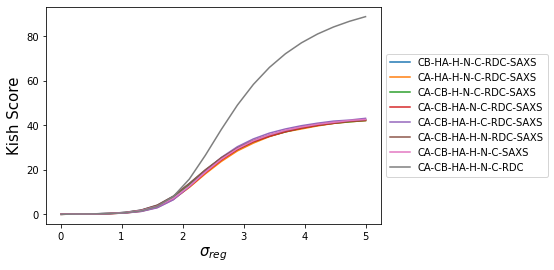

In [104]:
for key in KishScan:
     plt.plot(KishScan[key]['kish'][:,0],KishScan[key]['kish'][:,1],label='%s'%key)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$\sigma_{reg}$',size=15)
plt.ylabel('Kish Score', size=15)
plt.savefig('%s/Kishscan.leave_one_out.pdf'%outdir)
plt.show()

In [111]:
def plot_Kish_RMSE(rmse_dict):
    for key in rmse_dict:
        rmse = []
        kish = []
        for i in rmse_dict[key].keys():
            kish.append(rmse_dict[key][i]['Kish'])
        for i in rmse_dict[key].keys():
            for key2 in rmse_dict[key][i]['v_f'].keys():
                rmse.append(rmse_dict[key][i]['v_f'][key2])
        plt.plot(kish,rmse,label=key2,color=colors[key2])
        plt.tick_params(labelsize=16)
        plt.legend(bbox_to_anchor=(1.0, 0.9), loc='upper left',fontsize = 12)
        plt.xlabel("Kish Score (%)", size = 16)
        plt.ylabel("RMSE", size=16)

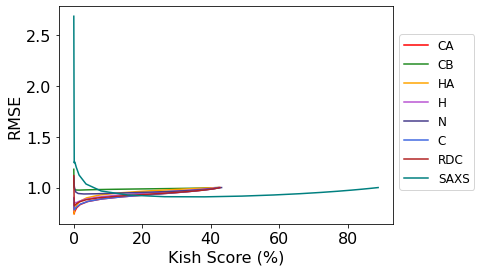

In [110]:
plot_Kish_RMSE(RMSE_leave_one_dict)

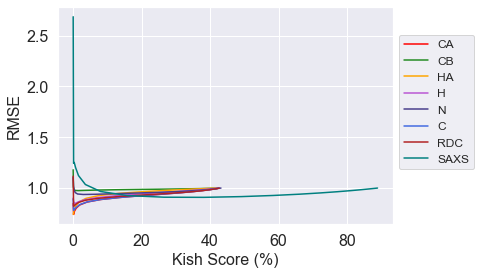

In [123]:
def plot_Kish_RMSE_normalized(rmse_dict):
    for key in rmse_dict:
        rmse = []
        kish = []
        for i in rmse_dict[key].keys():
            kish.append(rmse_dict[key][i]['Kish'])
        for i in rmse_dict[key].keys():
            for key2 in rmse_dict[key][i]['v_f'].keys():
                rmse.append(rmse_dict[key][i]['v_f'][key2])
        plt.plot(kish,rmse/rmse[0],label=key2,color=colors[key2])
        plt.tick_params(labelsize=16)
        plt.legend(bbox_to_anchor=(1.0, 0.9), loc='upper left',fontsize = 12)
        plt.xlabel("Kish Score (%)", size = 16)
        plt.ylabel("RMSE", size=16)
        
plot_Kish_RMSE_normalized(RMSE_leave_one_dict)

Reweight Data = CB-HA-H-N-C-RDC-SAXS
2.64
CB
RMSD_initial: 0.422 RMSD_final: 0.436
CA
RMSD_initial: 0.661 RMSD_final: 0.590
HA
RMSD_initial: 0.113 RMSD_final: 0.116
CA
RMSD_initial: 0.661 RMSD_final: 0.590
H
RMSD_initial: 0.171 RMSD_final: 0.152
CA
RMSD_initial: 0.661 RMSD_final: 0.590
N
RMSD_initial: 0.985 RMSD_final: 0.862
CA
RMSD_initial: 0.661 RMSD_final: 0.590
C
RMSD_initial: 0.644 RMSD_final: 0.499
CA
RMSD_initial: 0.661 RMSD_final: 0.590
RDC
RMSD_initial: 4.087 RMSD_final: 1.523
RMSD initial scale: 4.087 RMSD final scale: 1.433
Q initial scale: 0.739 Q final scale: 0.259
CA
RMSD_initial: 0.661 RMSD_final: 0.590
SAXS
RMSD_initial: 0.080 RMSD_final: 0.060
CA
RMSD_initial: 0.661 RMSD_final: 0.590
CB-HA-H-N-C-RDC-SAXS Theta: 2.6363157894736844 Kish:  0.315617 RMSD initail: 1.5682 RMSD final: 0.6919
Initial RMSE reweight data 
 * Total :      1.568
 *    CB :      0.422
 *    HA :      0.113
 *     H :      0.171
 *     N :      0.985
 *     C :      0.644
 *    RDC :      4.087
 *  

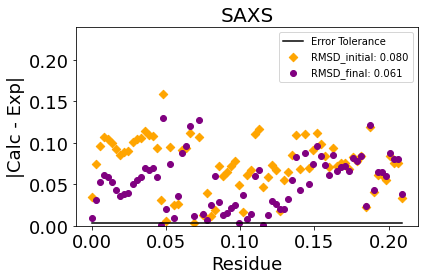

In [113]:
To_Scan=new_rwt_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)      
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(outdir,CS) 
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    
    compare=[]
    compare_dict_r = { key: {} for key in compdata.keys()}
    compare_dict_v = { key: {} for key in compdata.keys()}
    
    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0, sd,compare_dict_v)
    
    
    theta_m = theta_dict_leave_one[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg=theta_m
    sigma_md=sigma_md_r
    
    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)
    
    
    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias=np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights/=np.sum(initial_weights)
        initial_obs_r=np.dot(traj_r,initial_weights)
        initial_obs_r
        exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
        calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
        qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)    
        qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
        
        if(qf_neg<qf_pos):
            c=-c_neg
        else:
            c = c_pos
        RDC_rows=np.where(data_r_type['RDC']==1)
        traj_r[RDC_rows]=traj_r[RDC_rows]*c
        
    
    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights/=np.sum(initial_weights)
        initial_obs_v=np.dot(traj_v,initial_weights)
        initial_obs_v
        exp_rdc=np.trim_zeros(obs_exp_v*data_v_type['RDC'])
        calc_rdc=np.trim_zeros(initial_obs_v*data_v_type['RDC'])
        qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)    
        qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
        
        if(qf_neg<qf_pos):
            c=-c_neg
        else:
            c = c_pos
        RDC_rows=np.where(data_v_type['RDC']==1)
        traj_v[RDC_rows]=traj_v[RDC_rows]*c
        
    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r=np.dot(traj_r,initial_weights)
    initial_obs_v=np.dot(traj_v,initial_weights)
      #if res.success: print("\nMinimization worked: {}\n".format(res.success))
      #else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
    final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
      # e) final average observables for reweighting and validation
    final_obs_r=np.dot(traj_r,final_weights)
    final_obs_v=np.dot(traj_v,final_weights)
      # g) calculating Kish effective size
    Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
    Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
      #print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
      #print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
    Kish_ratio = (Ks_a/Ks_b)*100
    RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
    RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))
    
    
    plot_func(final_weights)
    
    print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
    
    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2)))
    
    for t in data_r_type:
        print(" *    %2s :" % t, end = '')
        print("     %6.3lf" % np.sqrt(np.sum((initial_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))

        if str(t)=='RDC': 
          qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
          #print(" *    RDC scaled RMSD:", end = '')
          #print(" %6.3lf" % rms_f)
          print(" *    RDC scaled Q:", end = '')
          print(" %6.3lf" % qf)
        
    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v-obs_exp_v)**2)))
    
    
    for t in data_v_type:
        print(" *    %2s :" % t, end= '')
        #(initial_obs_v-obs_exp_v)**2*data_v_type[t])
        print("     %6.3lf" % np.sqrt(np.sum((initial_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
        if str(t)=='RDC': 
          qi,rms_i,qf,rms_f,rdc_scale_i,c=scale_rdc_Q(initial_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
          #print(" *    RDC scaled RMSD:", end = '')
          #print(" %6.3lf" % rms_f)
          print(" *    RDC scaled Q:", end = '')
          print(" %6.3lf" % qf)
        
    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r-obs_exp_r)**2)))
    
    
    for t in data_r_type:
        print(" *    %2s :" % t, end = '')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_r-obs_exp_r)**2*data_r_type[t])/np.sum(data_r_type[t])))
        if str(t)=='RDC': 
          qi,rms_i,qf,rms_f,rdcs_scale_f,c=scale_rdc_Q(final_obs_r*data_r_type['RDC'],obs_exp_r*data_r_type['RDC'])
          #print(" *    RDC RMSE_scale:", end = '')
          #print(" %6.3lf" % rms_f)
          print(" *    RDC Q_scaled:", end = '')
          print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v-obs_exp_v)**2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end = '')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_v-obs_exp_v)**2*data_v_type[t])/np.sum(data_v_type[t])))
        if str(t)=='RDC': 
          qi,rms_i,qf,rms_f,rdc_scale_f,c=scale_rdc_Q(final_obs_v*data_v_type['RDC'],obs_exp_v*data_v_type['RDC'])
          #print(" *    RDC RMSE_scale:", end = '')
          #print(" %6.3lf" % rms_f)
          print(" *    RDC Q_scaled:", end = '')
          print(" %6.3lf" % qf)
    np.savetxt('%s/weights_final.dat'%(CS_dir),final_weights,fmt=" %6.12lf")
    # print final weights to file

    f=open("%s/weights_final.a.dat"%CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()                

In [114]:
keys = list(theta_dict_leave_one.keys())
keys2 = list(np.round(np.array(list(theta_dict_leave_one.values())),2))
keys2 = ["{:.2f}".format(value) for value in keys2]
keys3 = list(theta_dict.keys())
dfs = []
columns = "initial,final".split(',')
data_f = []
data_i = []
for k,k2 in zip(keys,keys2):
    if k2 == "0.0":k2 += "0"
    d_f = []
    d_i = []
    klist = k.split("-")
    for k3 in keys3:
        if k3 in set(klist):
            d_f.append(RMSE_leave_one_dict[k][k2]["r_f"][k3])
            d_i.append(RMSE_leave_one_dict[k][k2]["r_i"][k3])
        else: 
            d_f.append(RMSE_leave_one_dict[k][k2]["v_f"][k3])
            d_i.append(RMSE_leave_one_dict[k][k2]["v_i"][k3])
    data_f.append(np.array(d_f))
    data_i.append(np.array(d_i))

data_mat_f = np.stack(data_f, axis=0)
data_mat_i = np.stack(data_i, axis=0)
left_out = [list(set(keys3)-set(k.split("-")))[0] for k in keys]


In [115]:
table_left_out = pd.DataFrame(data=data_f, index=left_out, columns=left_out)

In [117]:
table_leave_one_out=pd.concat([subframes_only_initial, subframes_combined, table_left_out])

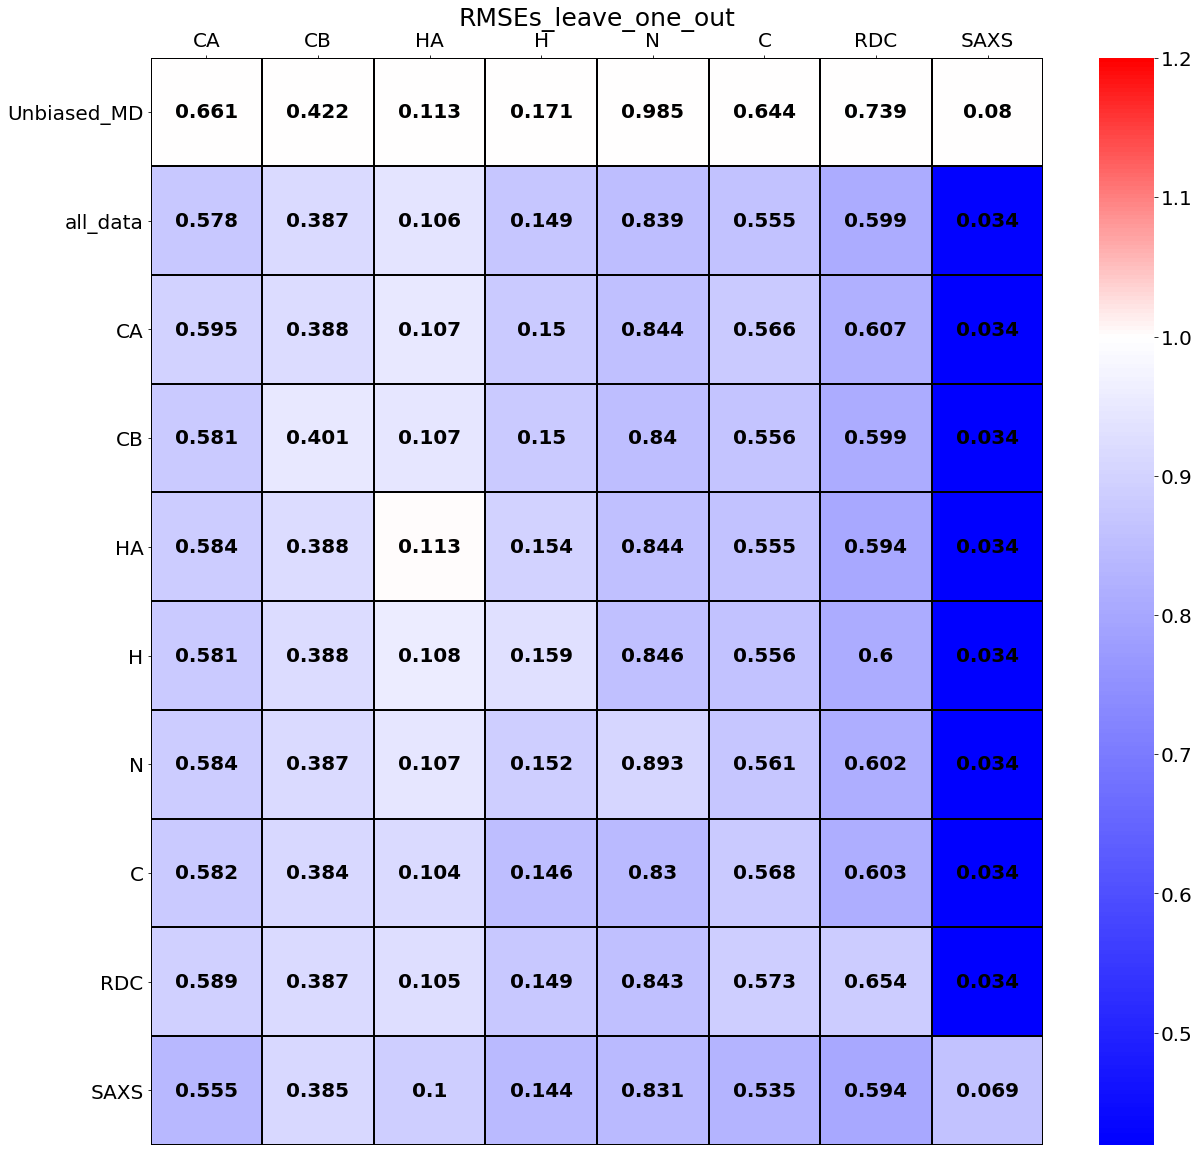

In [118]:
import matplotlib
def plot_mat(df,title,unit,cbarlabel,
                   textsize,textcolor,cmap):
        """mat = square matrix
        unit = string specifying the units"""
        #ratio = emat/mat
        mat = df.to_numpy()
        ratio = mat/mat[0,:]
        divnorm=matplotlib.colors.TwoSlopeNorm(vmin=ratio.min(), vcenter=1., vmax=1.2)
        fig,ax = plt.subplots(1,figsize=(20,20))
        s = sns.heatmap(pd.DataFrame(ratio,index=table.index, columns = table.columns),linewidths=1,
                        linecolor='black', cmap=cmap,norm=divnorm,ax=ax)
        #s = ax.imshow(ratio, cmap=cmap)
        for i in range(len(mat)):
            for j in range(mat.shape[1]):
                c = mat[i,j]
                ax.text(j+.5,i+.5,f"{np.round(c,3)}{unit}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax.tick_params(labelsize=20,top=True)
        ax.tick_params(axis="y",rotation=0)
#         cb = plt.colorbar(s,label=cbarlabel,fraction=0.046,pad=0.04)
#         cb.set_label(cbarlabel, size=40)
#         cb.ax.tick_params(labelsize=30)
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=20)
        ax.set_title(title, size = 25)
        ax.xaxis.tick_top()
        ax.grid(b=True,which='minor',color='black', linestyle='-', linewidth=1, alpha=0.2)
        #plt.minorticks_on()
        
        plt.savefig('%s/RMSE_TABLE_LEAVE_ONE.pdf'%outdir)
        plt.show()
        return
plot_mat(table_leave_one_out,"RMSEs_leave_one_out", "","final / initial",20,"black","bwr")

In [120]:
diagon_array = np.diagonal(data_f)
table_left_out = pd.DataFrame(data=diagon_array, columns=['Cross_Validation'], index=left_out).T
table_left_out = pd.concat([subframes_only_initial, subframes_combined, table_left_out]).round(3)

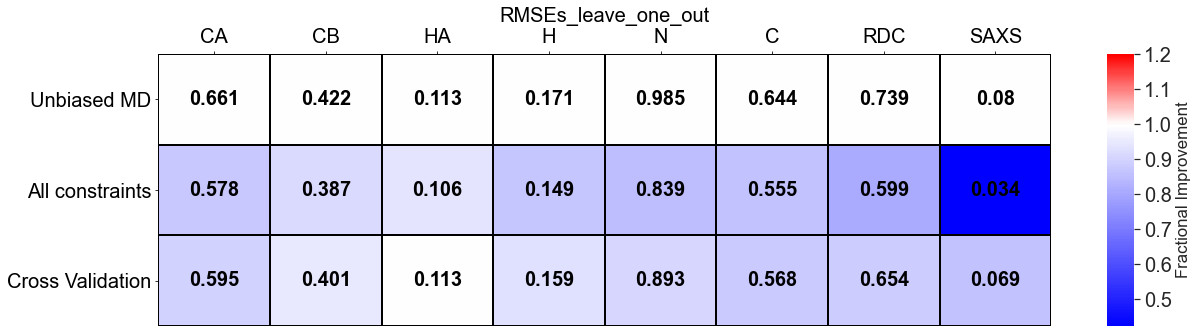

In [121]:
import matplotlib
def plot_mat(df,title,unit,cbarlabel,
                   textsize,textcolor,cmap):
        """mat = square matrix
        unit = string specifying the units"""
        #ratio = emat/mat
        mat = df.to_numpy()
        ratio = mat/mat[0,:]
        index = ['Unbiased MD', 'All constraints', 'Cross Validation']
        divnorm=matplotlib.colors.TwoSlopeNorm(vmin=ratio.min(), vcenter=1., vmax=1.2)
        fig,ax = plt.subplots(1,figsize=(20,5))
        sns.set(font_scale=1.4)
        ax = sns.heatmap(pd.DataFrame(ratio,index=index, columns = table_left_out.columns),linewidths=1,
                        linecolor='black', cmap=cmap,norm=divnorm,ax=ax, cbar_kws={'label': 'Fractional Improvement','aspect':10})
        for i in range(len(mat)):
            for j in range(mat.shape[1]):
                c = mat[i,j]
                ax.text(j+.5,i+.5,f"{np.round(c,3)}{unit}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        cax = plt.gcf().axes[-1]
        cax.tick_params(labelsize=20)
        ax.tick_params(labelsize=20,top=True)
        ax.tick_params(axis="y",rotation=0)
        ax.set_title(title, size = 20)
        ax.xaxis.tick_top()
        ax.grid(b=True,which='minor',color='black', linestyle='-', linewidth=1, alpha=0.2)
        #plt.minorticks_on()
        
        plt.savefig('%s/RMSE_TABLE_LEAVE_ONE.pdf'%outdir)
        plt.show()
        return
plot_mat(table_left_out,"RMSEs_leave_one_out", "","final / initial",20,"black","bwr")

CB-HA-H-N-C-RDC-SAXS
CA-HA-H-N-C-RDC-SAXS
CA-CB-H-N-C-RDC-SAXS
CA-CB-HA-N-C-RDC-SAXS
CA-CB-HA-H-C-RDC-SAXS
CA-CB-HA-H-N-RDC-SAXS
CA-CB-HA-H-N-C-SAXS
CA-CB-HA-H-N-C-RDC


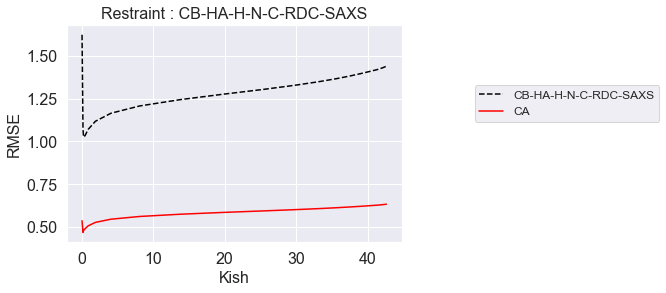

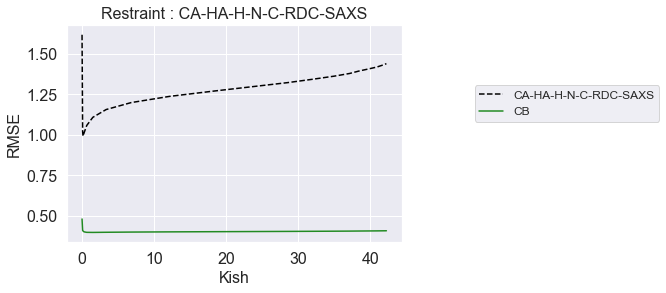

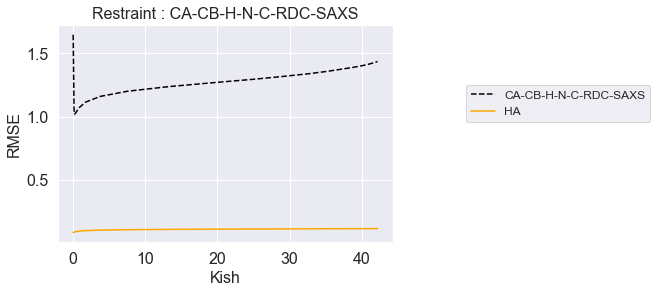

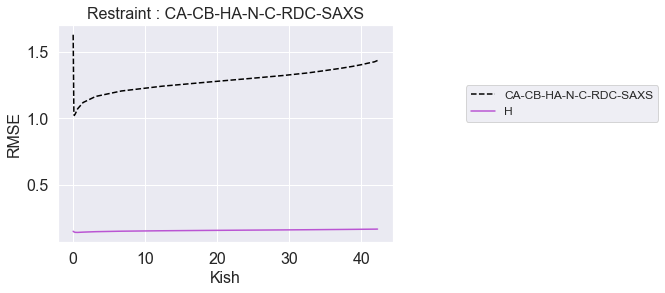

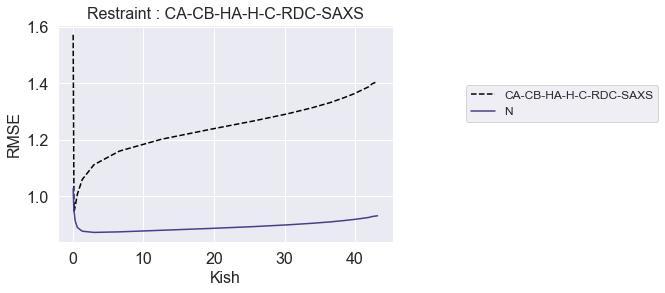

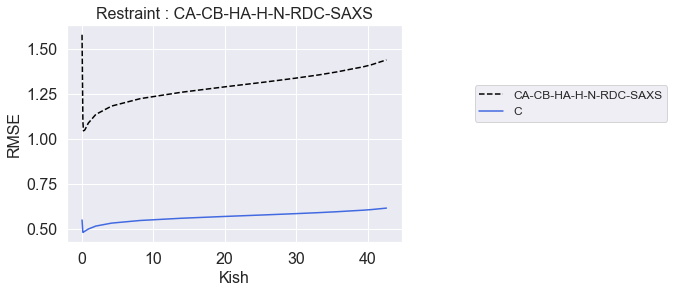

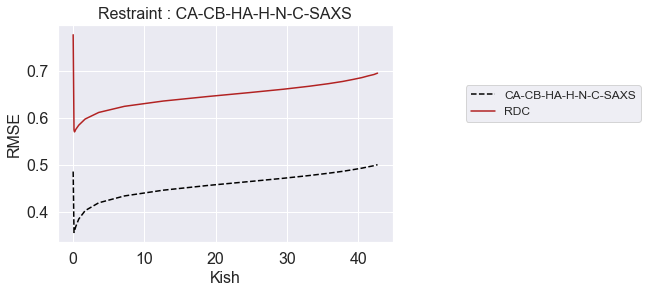

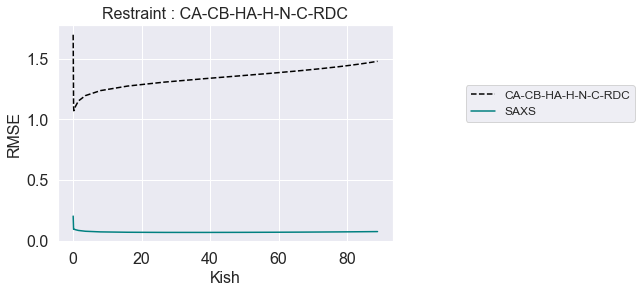

In [122]:
for key in RMSE_leave_one_dict:
   print(key)
   kish=[]
   theta=[]
   rmse_r=[]
   for i in RMSE_leave_one_dict[key].keys():
    kish.append(RMSE_leave_one_dict[key][i]['Kish'])
    theta.append(i)
    rmse_r.append(RMSE_leave_one_dict[key][i]['r_f']['Tot'])
   theta_rev=np.asarray(theta,dtype=float)[::-1]
   rmse_r_rev=np.asarray(rmse_r,dtype=float)[::-1]
   kish_rev=np.asarray(kish,dtype=float)[::-1]
   f, ax = plt.subplots()
   ax.plot(kish_rev,rmse_r_rev,label=key,c='black',linestyle='dashed')
   for key2 in RMSE_leave_one_dict[key][i]['v_f'].keys():
     rmse_v=[]
     for k in RMSE_leave_one_dict[key].keys():
      rmse_v.append(RMSE_leave_one_dict[key][k]['v_f'][key2])
     rmse_v_rev=np.asarray(rmse_v,dtype=float)[::-1]
     ax.plot(kish_rev,rmse_v_rev,label=key2,color = colors[key2])
    
   ax.tick_params(labelsize=16)
   ax.legend(bbox_to_anchor=(1.2, 0.75), loc='upper left',fontsize = 12)
   ax.set_title(f"Restraint : {key}", size= 16)
   ax.set_xlabel("Kish", size = 16)
   ax.set_ylabel("RMSE", size=16)
